# Neural Network Mortgage Prepayment Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

### Load data from csv files in the ./data directory

In [2]:
if True:
    # load data from csv files
    df = pd.DataFrame()
    for root, dirs, files in os.walk("./data"):
        for name in files:
            file_name = os.path.join(root, name)
            if 'pools_ge250_loans' in file_name:
                if len(df) > 0:
                    df = pd.concat([df,pd.read_csv(file_name)])
                else:
                    df = pd.read_csv(file_name)        

    model_name = 'nn-ppm-from-csv.h5' # for saving a model later

else:
    dill.load_session('notebook_env_all_3_dfs.db')

    print('Loaded data as is:')
    print('attr_df.shape   = ', attr_df.shape)
    print('geo_df.shape    = ', geo_df.shape)
    print('seller_df.shape = ', seller_df.shape)

    nloans = 250
    attr_df = attr_df[attr_df['cnloans']>=nloans]

    print('Data size after filtering for >= 250 loans:')
    print(f'attr_df.shape = {attr_df.shape}')

    geo_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(attr_df,geo_df,on=['cusip','asofdate'],how='left')

    seller_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(df,seller_df,on=['cusip','asofdate'],how='left')

    df.fillna(0,inplace=True)

    model_name = 'nn-ppm-dill-data.h5' # for saving a model later

df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

print('df.shape = ', df.shape)

df.shape =  (594533, 111)


#### Make sure all the fields (except cusip and poolsno) are numerical and there are no NAs

In [3]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594533 entries, 0 to 29999
Data columns (total 111 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   poolno              594533 non-null  object 
 1   asofdate            594533 non-null  int64  
 2   cusip               594533 non-null  object 
 3   spread              594533 non-null  float64
 4   SMM                 594533 non-null  float64
 5   DayCount            594533 non-null  float64
 6   OBal                594533 non-null  float64
 7   CBal                594533 non-null  float64
 8   factor              594533 non-null  float64
 9   Coupon              594533 non-null  float64
 10  Wac                 594533 non-null  float64
 11  Wam                 594533 non-null  float64
 12  Age                 594533 non-null  float64
 13  aols                594533 non-null  float64
 14  waols               594533 non-null  float64
 15  ONLoans             594533 non-nul

In [4]:
df.head()

poolno  asofdate      cusip  spread     SMM  DayCount         OBal  \
0  AJ4035    201405  3138AVPV1   -17.2  1.5337      21.0  564570411.0   
1  AJ4035    201406  3138AVPV1    -9.7  1.2029      21.0  564570411.0   
2  AJ4035    201407  3138AVPV1    -0.9  1.3777      22.0  564570411.0   
3  AJ4035    201408  3138AVPV1     2.3  0.7740      21.0  564570411.0   
4  AJ4035    201409  3138AVPV1     4.5  0.9515      21.0  564570411.0   

           CBal     factor  Coupon  ...  SellerPct_NATIONST  SellerPct_NRESM  \
0  2.922287e+08  51.761249     3.5  ...                 0.0              0.0   
1  2.882252e+08  51.052132     3.5  ...                 0.0              0.0   
2  2.837712e+08  50.263205     3.5  ...                 0.0              0.0   
3  2.810938e+08  49.788969     3.5  ...                 0.0              0.0   
4  2.779412e+08  49.230558     3.5  ...                 0.0              0.0   

   SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  SellerPct_REG  \
0               0.0               0.0              0.0            0.0   
1               0.0               0.0              0.0            0.0   
2               0.0               0.0              0.0            0.0   
3               0.0               0.0              0.0            0.0   
4               0.0               0.0              0.0            0.0   

   SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  Seasonality  
0             0.0               0.0           100.0            5  
1             0.0               0.0           100.0            6  
2             0.0               0.0           100.0            7  
3             0.0               0.0           100.0            8  
4             0.0               0.0           100.0            9  

[5 rows x 111 columns]

### Exploratory data analysis

Here we show some of the typical dependencies between prepayment speeds and some of the pools attributes.

* Prepayment speeds tend to be faster for loans of higher sizes.
* Prepayment speeds tend to be slower for investor loans, because investor loans have much higher closing costs and thus, more expensive to refinance. 
* It does matter which financial institution has originated a loan. The example we give here is comparing loans originated by Quicken to the rest of the loan population. Quicken loans tend to be much faster and it's imoprtant for a model to capture that. 

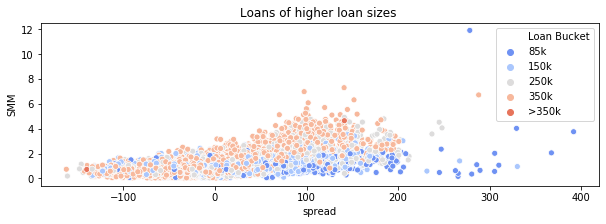

In [5]:
temp = df[(df['Age']>=24) & (df['cnloans']>500)].sample(10000)

temp['Loan Bucket'] = temp['waols'].apply(lambda x: '85k' if x<=85e3 
                                                          else '150k' if x<=150e3 
                                                          else '250k' if x<=250e3 
                                                          else '350k' if x<=350e3
                                                          else '>350k')

plt.figure(figsize=(10,3))
plt.title('Loans of higher loan sizes ')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='Loan Bucket',
                hue_order=['85k','150k','250k','350k','>350k'],
                palette='coolwarm')

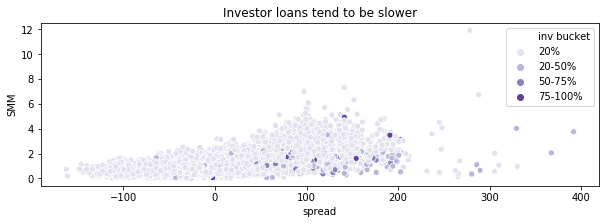

In [6]:
temp['inv bucket'] = temp['OccPct_investor'].apply(lambda x: '20%' if x<20
                                                  else '20-50%' if x<50
                                                  else '50-75%' if x<75
                                                  else '75-100%')
plt.figure(figsize=(10,3))
plt.title('Investor loans tend to be slower')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='inv bucket',palette='Purples',hue_order=['20%','20-50%','50-75%','75-100%'])

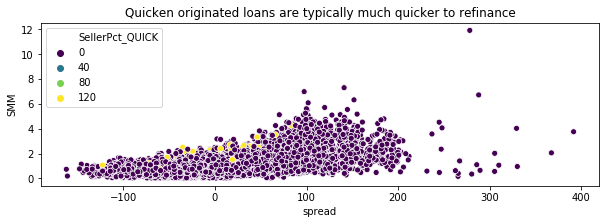

In [7]:
plt.figure(figsize=(10,3))
plt.title('Quicken originated loans are typically much quicker to refinance')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='SellerPct_QUICK',palette='viridis')

### Model building and fitting

* Here we select the data columns to use as features in the model and fit a FF neural-network style model to all prepayment data observed before 2017. Then we test the model on historical data observed in 2017-present. 
* Note that in our approach we use a rather large test(out of sample) period. Typically, prepayment models in the mortgage industry are updated every 6m to 1 year. 
* Even before we begin building and testing the model we should accept that there are many factors in play which are outside of the scope of the data available to build such models. For example, changes in regulation and mortgage industry headcount can have a very large impact on loans propensity to refinance. There are many other factors. 

In [8]:
model_columns = ['asofdate',
                 'SMM',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                 'Seasonality',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM']

dfm = df[model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.head()

dfm.shape = (594533, 103)


asofdate     SMM  spread  DayCount     factor    Wac    Wam   Age  \
0    201405  1.5337   -17.2      21.0  51.761249  4.169  322.0  32.0   
1    201406  1.2029    -9.7      21.0  51.052132  4.168  321.0  33.0   
2    201407  1.3777    -0.9      22.0  50.263205  4.168  320.0  34.0   
3    201408  0.7740     2.3      21.0  49.788969  4.169  319.0  35.0   
4    201409  0.9515     4.5      21.0  49.230558  4.168  318.0  36.0   

       aols     waols  ...  SellerPct_NCM  SellerPct_NATIONST  \
0  305574.0  305574.0  ...            0.0                 0.0   
1  304845.0  304845.0  ...            0.0                 0.0   
2  304524.0  304524.0  ...            0.0                 0.0   
3  304414.0  304414.0  ...            0.0                 0.0   
4  304682.0  304682.0  ...            0.0                 0.0   

   SellerPct_NRESM  SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  \
0              0.0               0.0               0.0              0.0   
1              0.0               0.0               0.0              0.0   
2              0.0               0.0               0.0              0.0   
3              0.0               0.0               0.0              0.0   
4              0.0               0.0               0.0              0.0   

   SellerPct_REG  SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  
0            0.0             0.0               0.0           100.0  
1            0.0             0.0               0.0           100.0  
2            0.0             0.0               0.0           100.0  
3            0.0             0.0               0.0           100.0  
4            0.0             0.0               0.0           100.0  

[5 rows x 103 columns]

In [9]:
dummies = pd.get_dummies(dfm['Seasonality'],drop_first=True)
dfm = dfm.drop('Seasonality',axis=1)
dfm = pd.concat([dfm,dummies],axis=1)

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (594533, 113)


In [10]:
# define train/test split
# from sklearn.model_selection import train_test_split

# X = dfm.drop(['SMM','asofdate'],axis=1)
# y = dfm['SMM'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

dfm_train = dfm[dfm['asofdate'] <  201701]
dfm_test  = dfm[dfm['asofdate'] >= 201701]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print('\n')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (328786, 111)
y_train.shape = (328786,)


X_test.shape  = (265747, 111)
y_test.shape  = (265747,)


In [11]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

In [59]:
model = Sequential()

#input layer / first hidden layer
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

# hidden layers
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dropout(0.5))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x
#model.add(Dense(1)) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='rmsprop', loss='mse')

In [60]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=1024,
          epochs=300)

Train on 328786 samples, validate on 265747 samples
Epoch 1/300
328786/328786 [==============================] - 8s 23us/sample - loss: 0.8364 - val_loss: 0.4356
Epoch 2/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.6173 - val_loss: 0.3599
Epoch 3/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.5340 - val_loss: 0.3402
Epoch 4/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4922 - val_loss: 0.3162
Epoch 5/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4673 - val_loss: 0.3212
Epoch 6/300
328786/328786 [==============================] - 8s 23us/sample - loss: 0.4507 - val_loss: 0.3513
Epoch 7/300
328786/328786 [==============================] - 8s 24us/sample - loss: 0.4352 - val_loss: 0.3358
Epoch 8/300
328786/328786 [==============================] - 7s 23us/sample - loss: 0.4245 - val_loss: 0.3254
Epoch 9/300
328786/328786 [==============================] - 7s 23us

328786/328786 [==============================] - 7s 22us/sample - loss: 0.3111 - val_loss: 0.2868
Epoch 148/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3103 - val_loss: 0.2888
Epoch 149/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3093 - val_loss: 0.2842
Epoch 150/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3096 - val_loss: 0.3017
Epoch 151/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3104 - val_loss: 0.2885
Epoch 152/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3093 - val_loss: 0.2873
Epoch 153/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3103 - val_loss: 0.2940
Epoch 154/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3095 - val_loss: 0.2915
Epoch 155/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3100 - val_loss: 0.2857
Epoch 

328786/328786 [==============================] - 7s 21us/sample - loss: 0.2984 - val_loss: 0.2881
Epoch 294/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2985 - val_loss: 0.2922
Epoch 295/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.2997 - val_loss: 0.2854
Epoch 296/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.2992 - val_loss: 0.2827
Epoch 297/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3000 - val_loss: 0.2868
Epoch 298/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2984 - val_loss: 0.2904
Epoch 299/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3015 - val_loss: 0.2849
Epoch 300/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2978 - val_loss: 0.2876


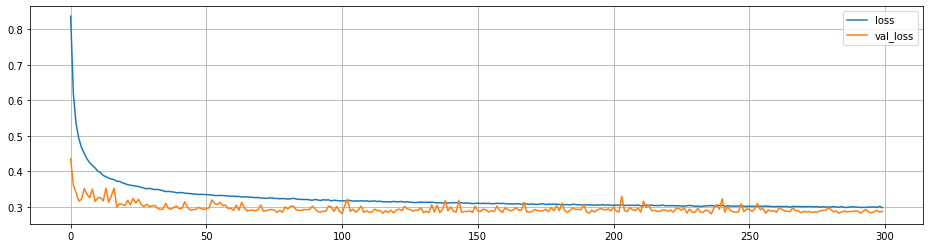

In [61]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

### Building a benchmark model 1 -- Linear regression

* Here we build a simple linear regression model and examine its predictive ability on our dataset.
* Linear regression is not scale-invariant model, so we use unscaled data for model fitting. 

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [43]:
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=4,verbose=1)

In [44]:
dfm_train = dfm[dfm['asofdate'] <  201701]
dfm_test  = dfm[dfm['asofdate'] >= 201701]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

In [45]:
linear_model.fit(X_train,y_train)
#rf_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
if 'asofdate' in dfm.columns:
    #df['model SMM'] = linear_model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
    df['model SMM'] = linear_model.predict(dfm.drop(['SMM','asofdate'],axis=1))
    #df['model SMM'] = rf_model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
else:
    df['model SMM'] = linear_model.predict(scaler.transform(dfm.drop('SMM',axis=1)))

In [47]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

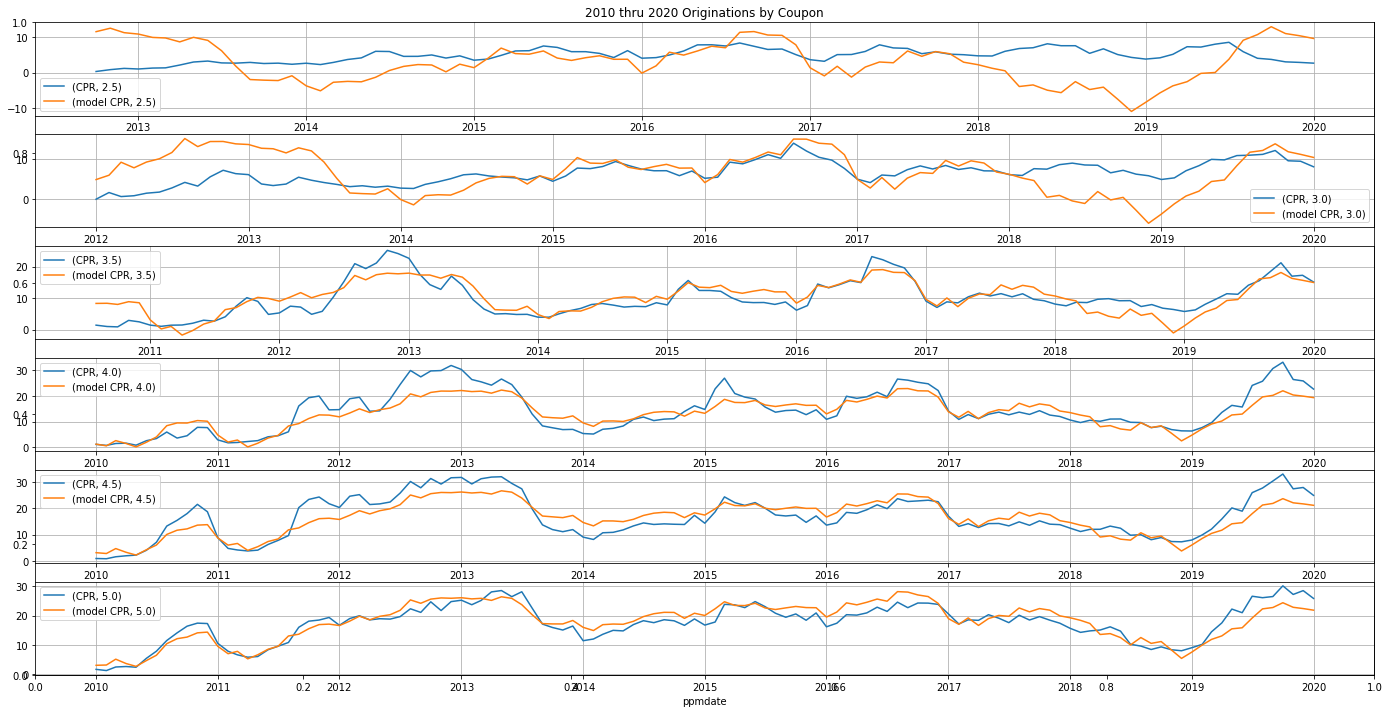

In [48]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

### Building a benchmark model 2 -- Random forest

* We thought it would be interesting to compare our neural network to a random forest

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [98]:
rf_model = RandomForestRegressor(n_estimators=100,verbose=1)
#dtree_model = DecisionTreeRegressor()

In [99]:
rf_model.fit(X_train,y_train)
#dtree_model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 32.5min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [100]:
if 'asofdate' in dfm.columns:
    #df['model SMM'] = dtree_model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
    #df['model SMM'] = dtree_model.predict(dfm.drop(['SMM','asofdate'],axis=1))
    #df['model SMM'] = rf_model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
    df['model SMM'] = rf_model.predict(dfm.drop(['SMM','asofdate'],axis=1))
else:
    df['model SMM'] = linear_model.predict(scaler.transform(dfm.drop('SMM',axis=1)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.2s finished


In [101]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

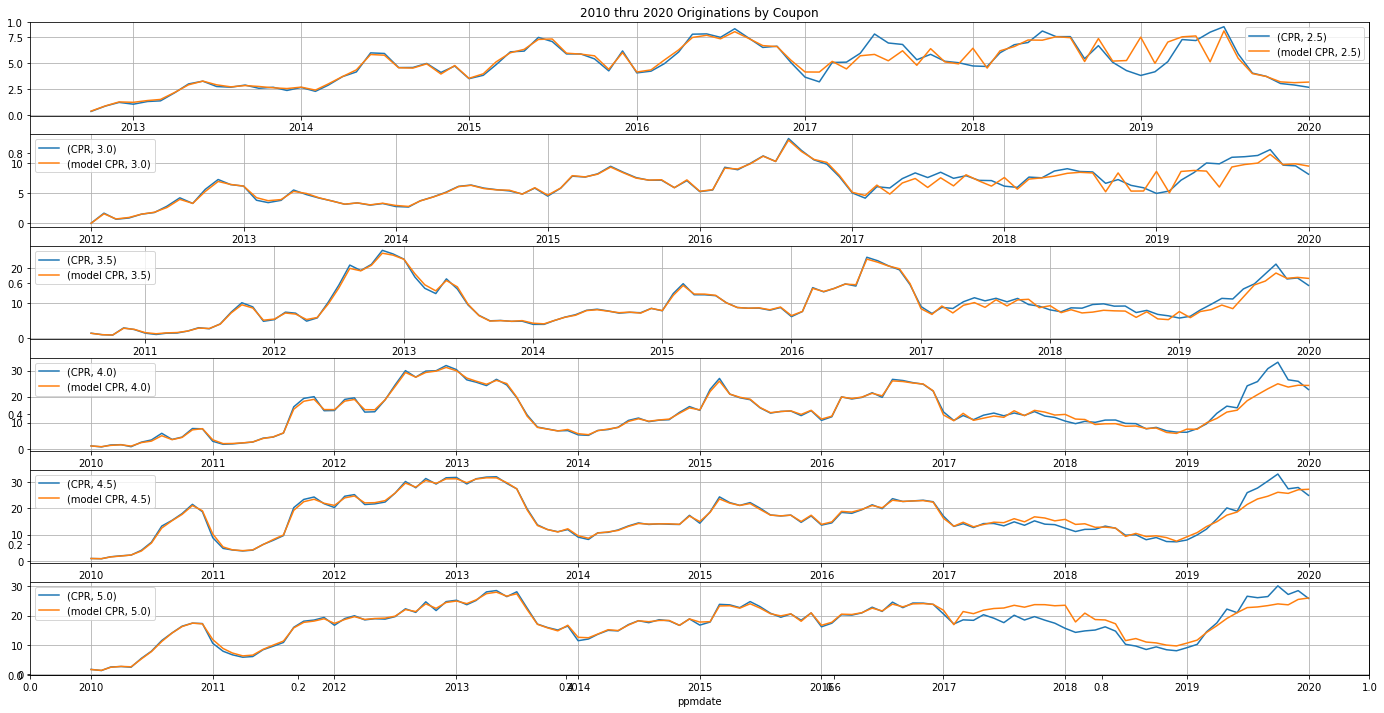

In [102]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

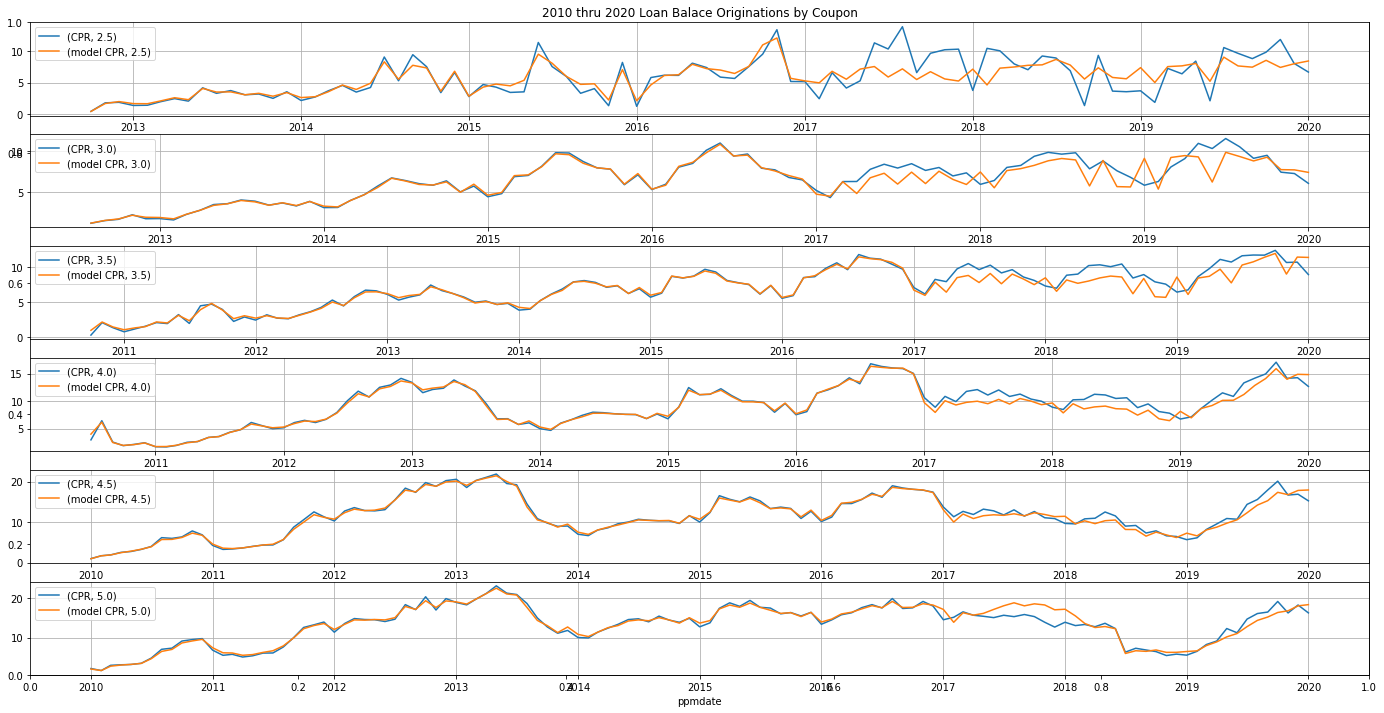

In [103]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

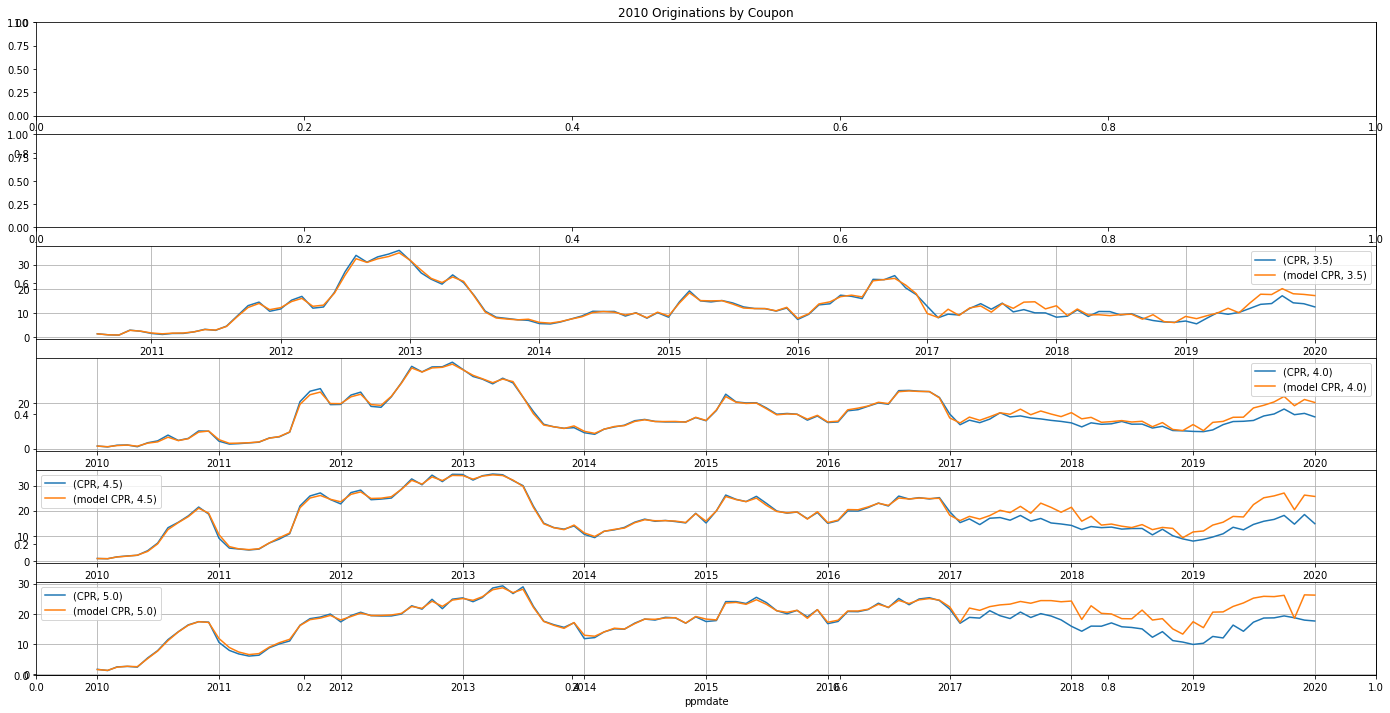

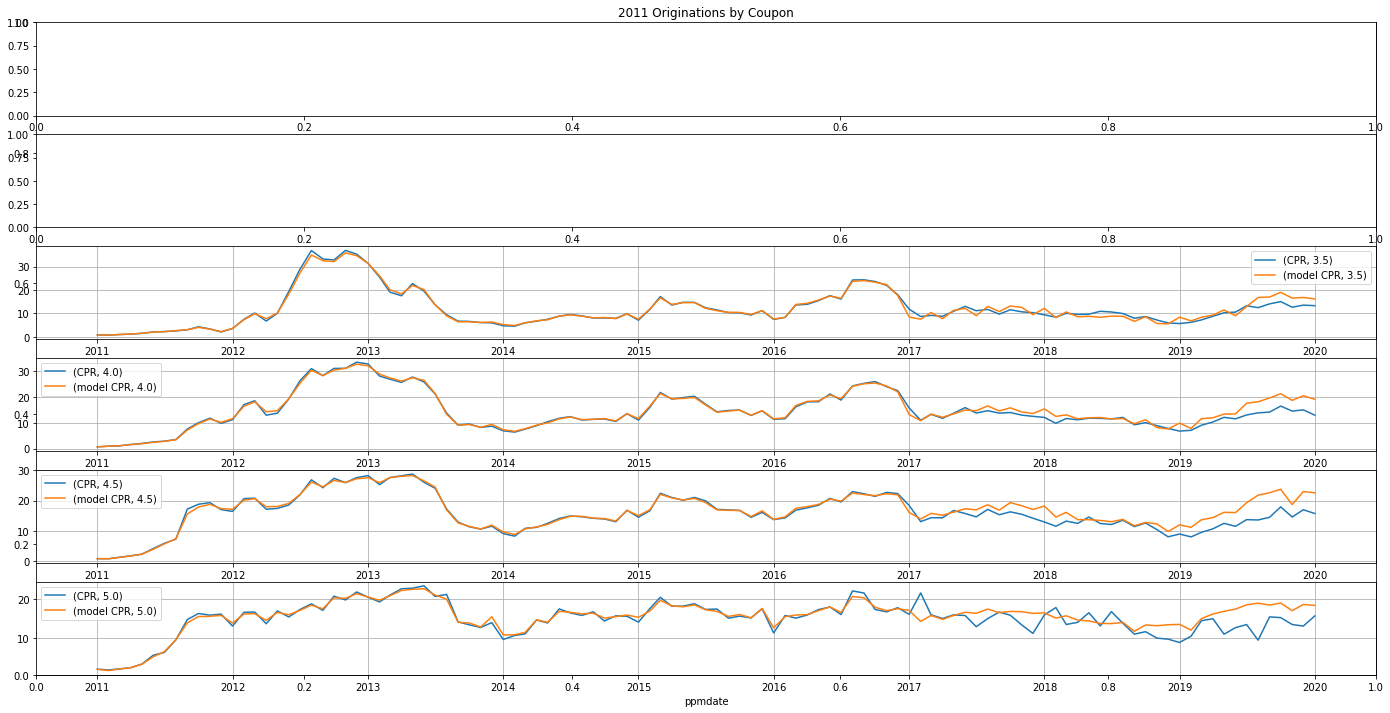

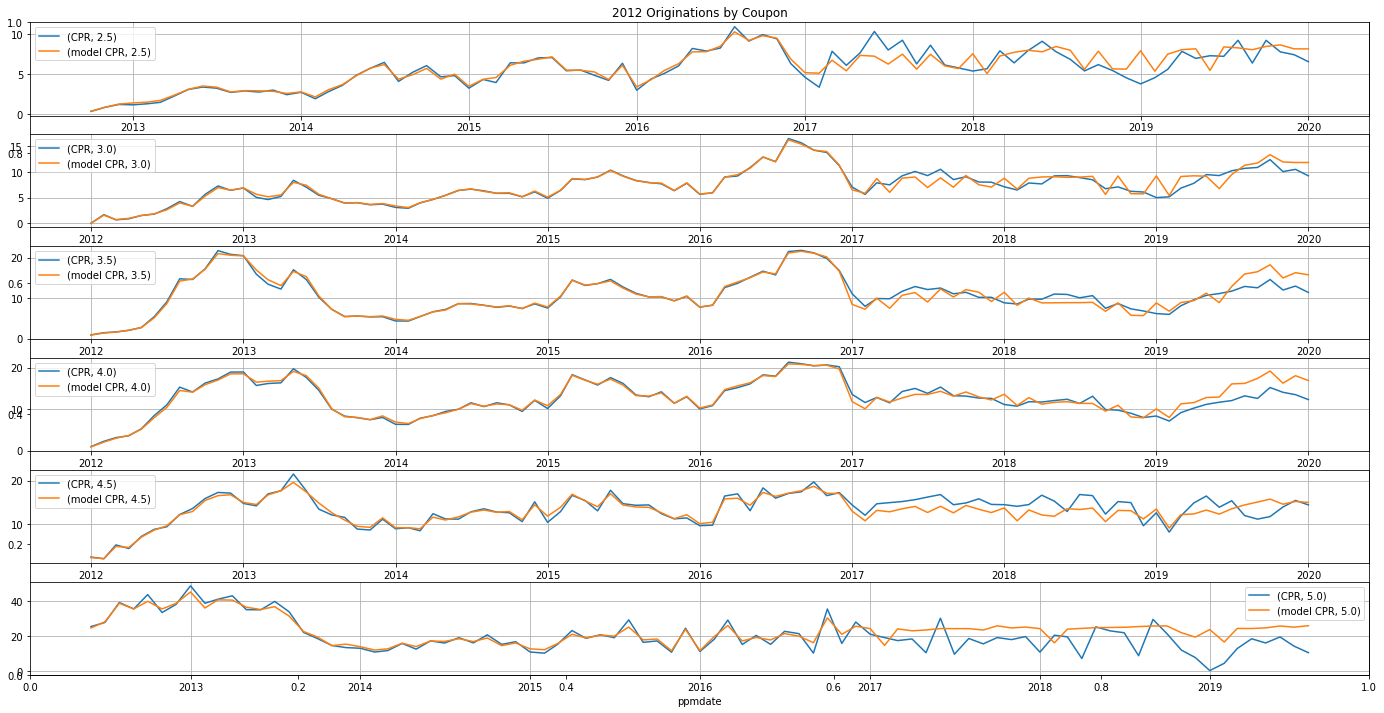

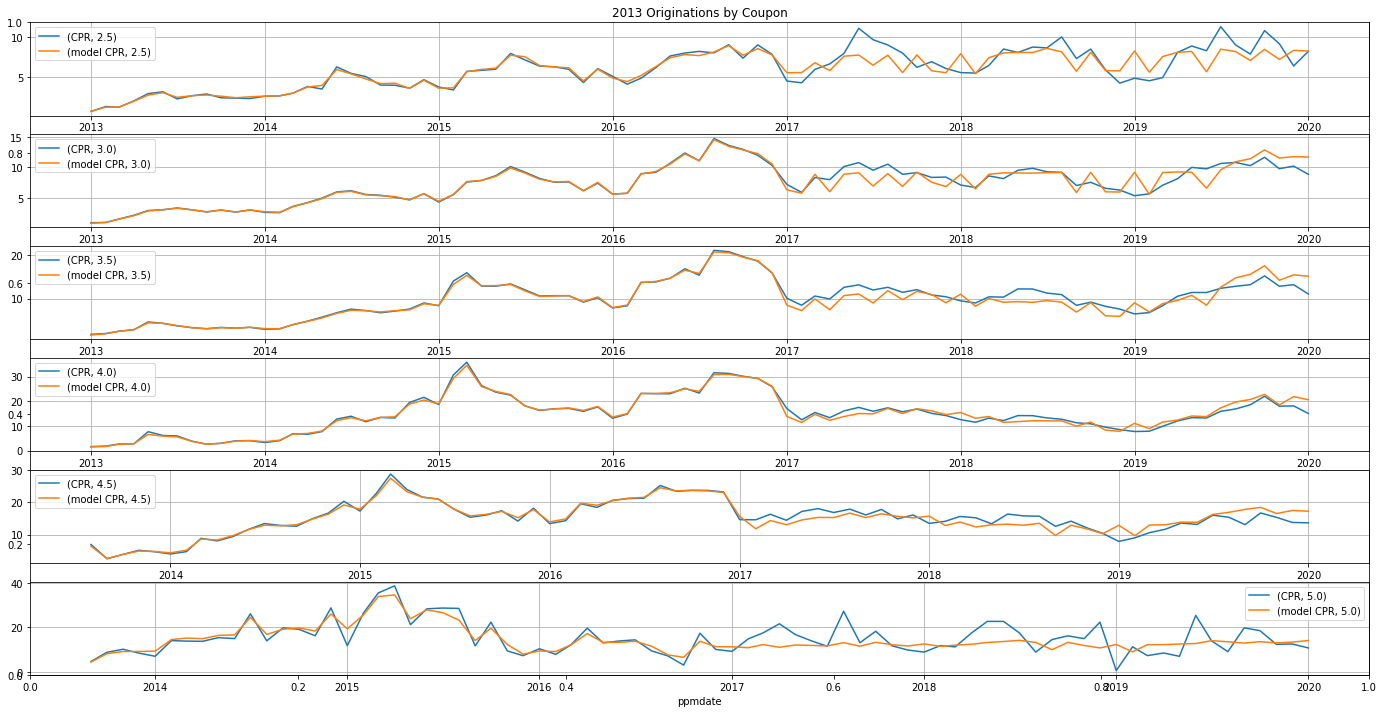

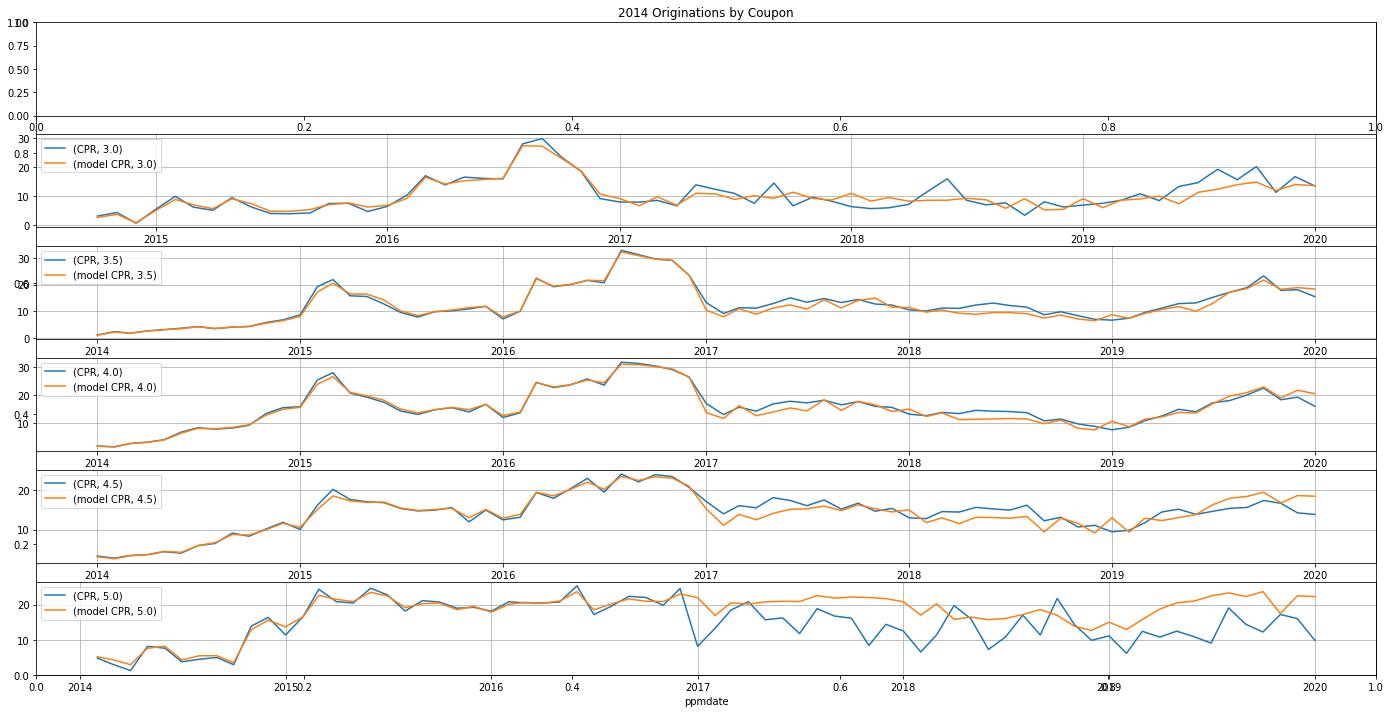

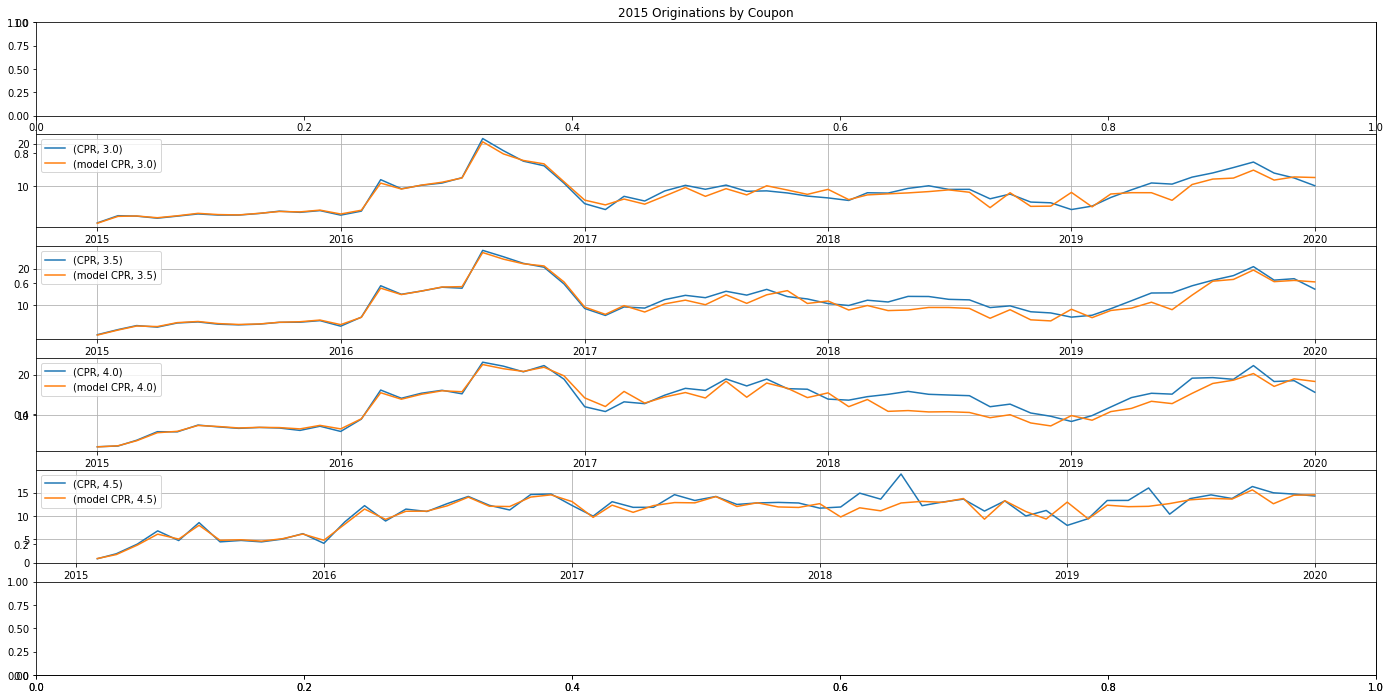

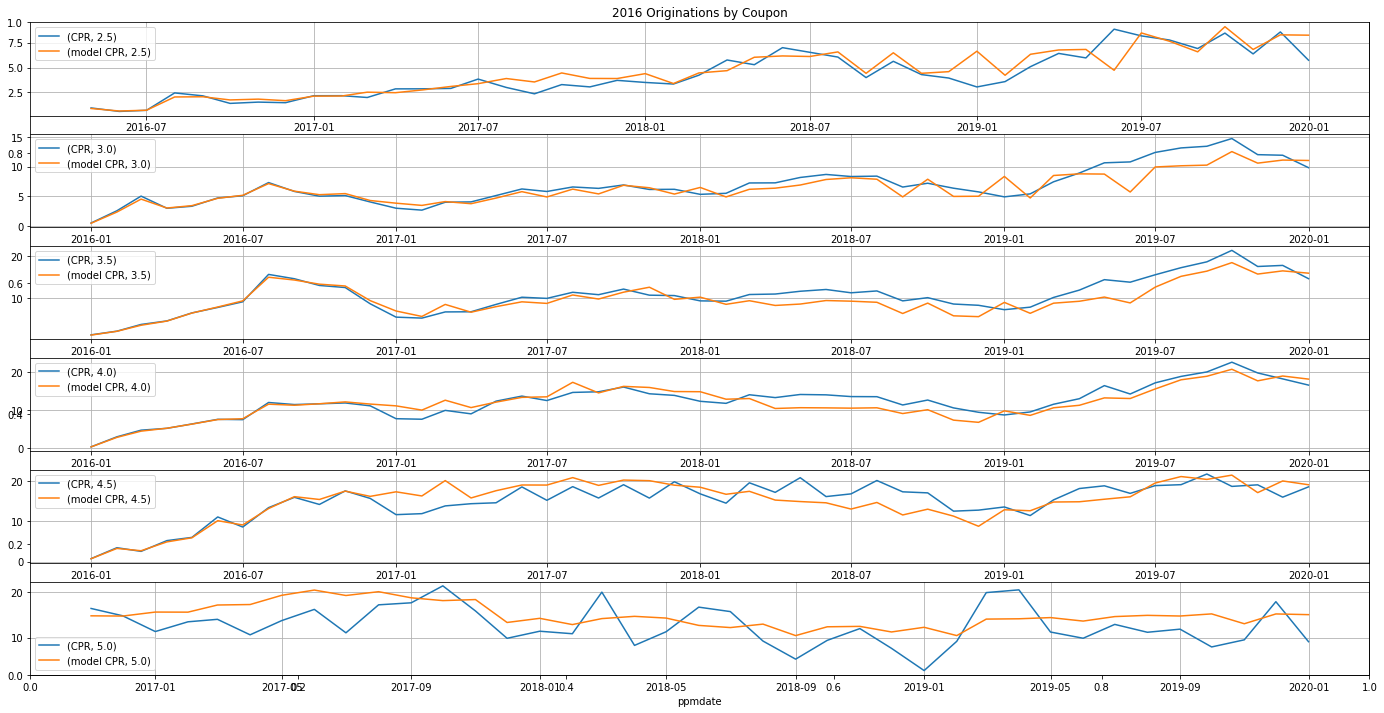

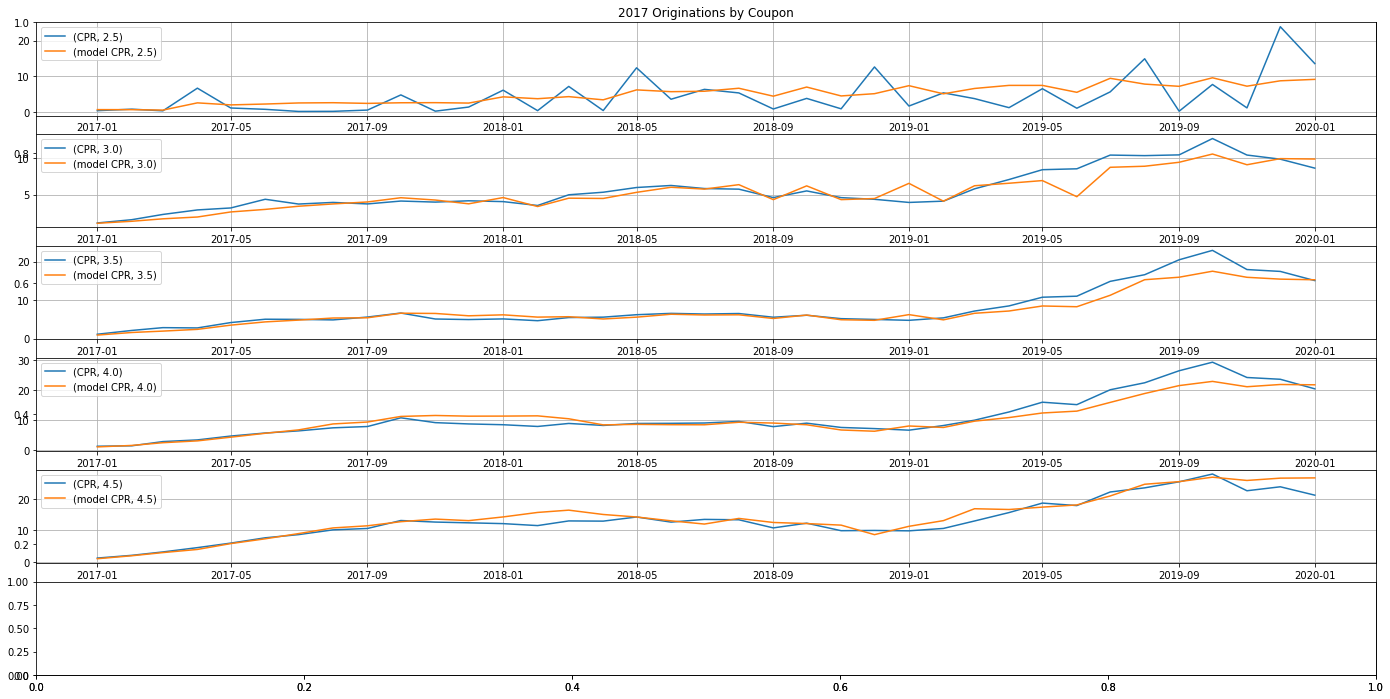

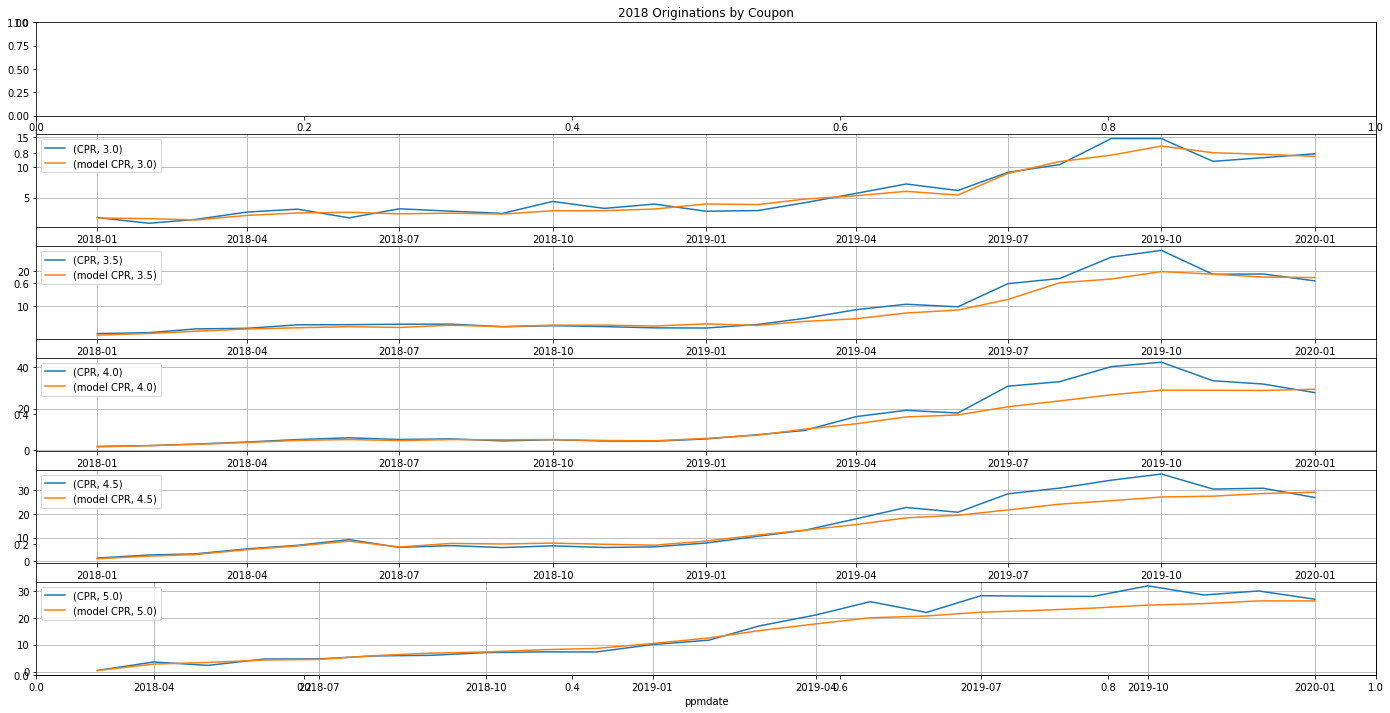

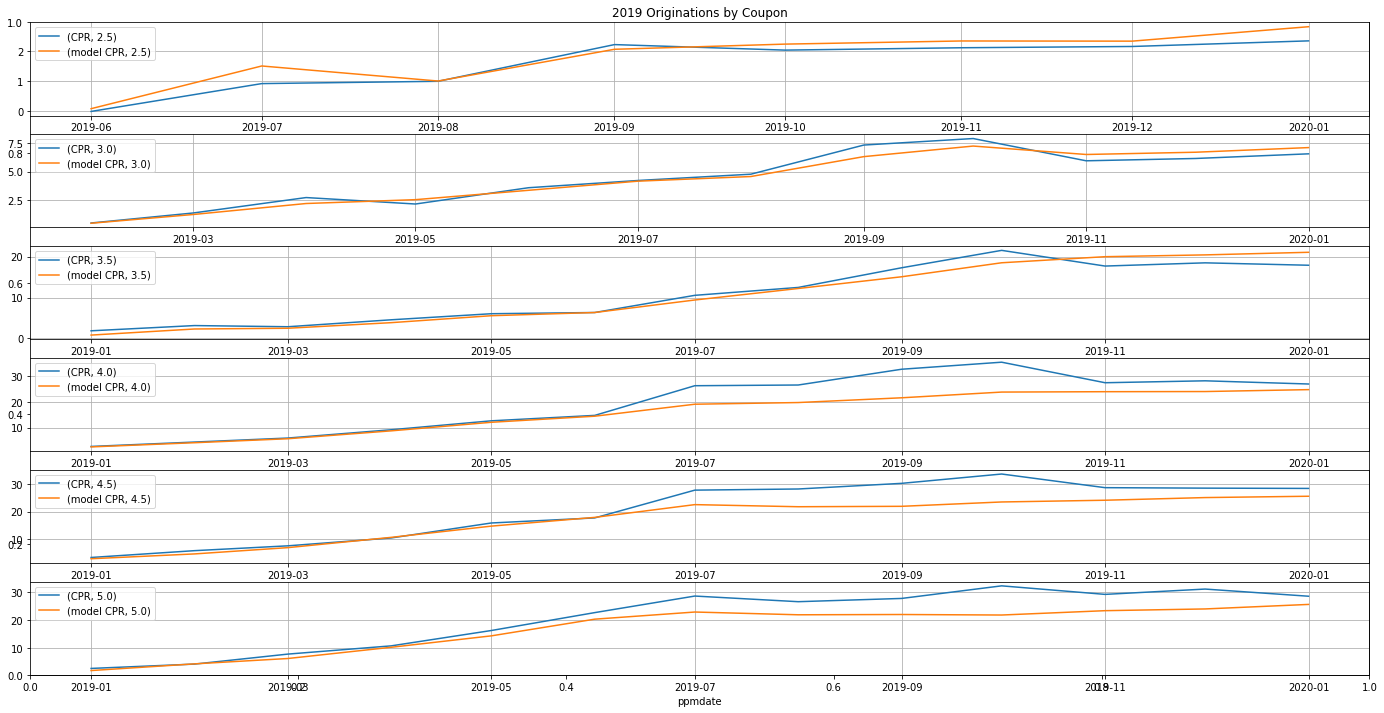

In [104]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:

    valReport(df[df['Vintage'] == vintage],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

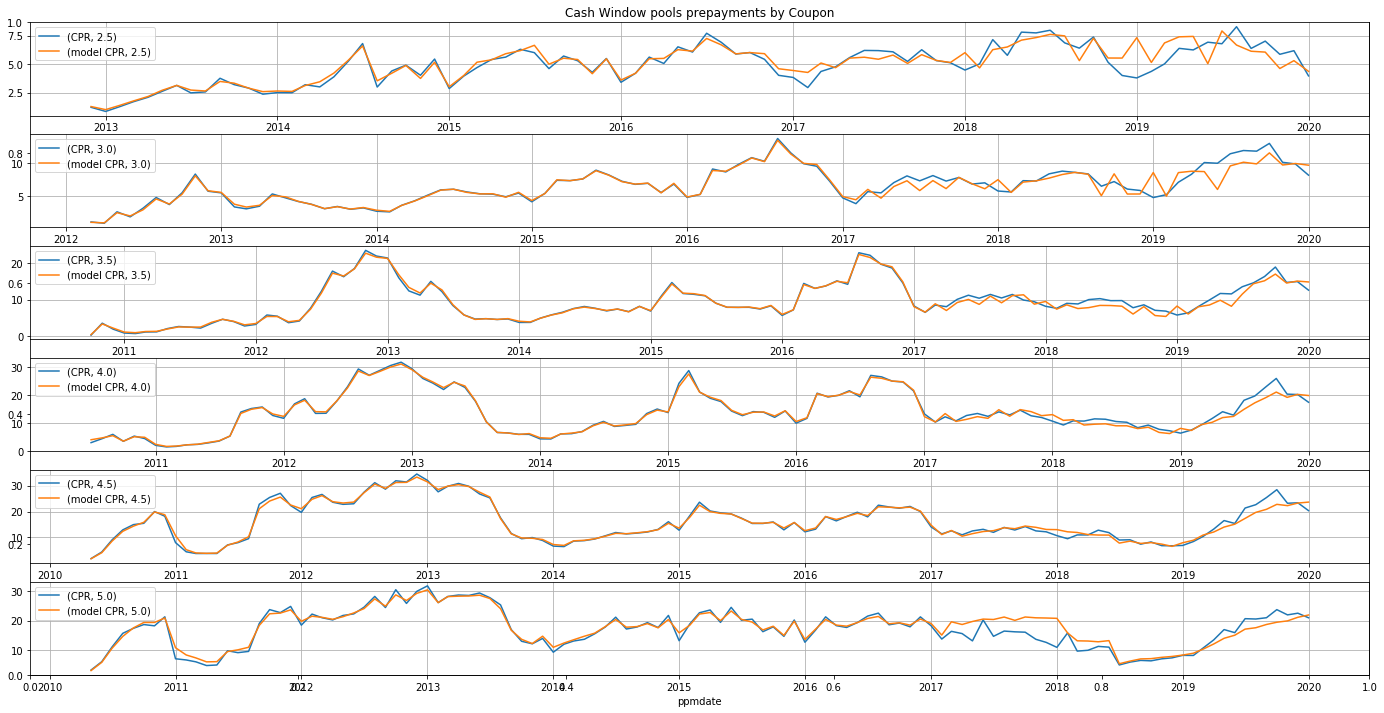

In [105]:
valReport(df[(df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

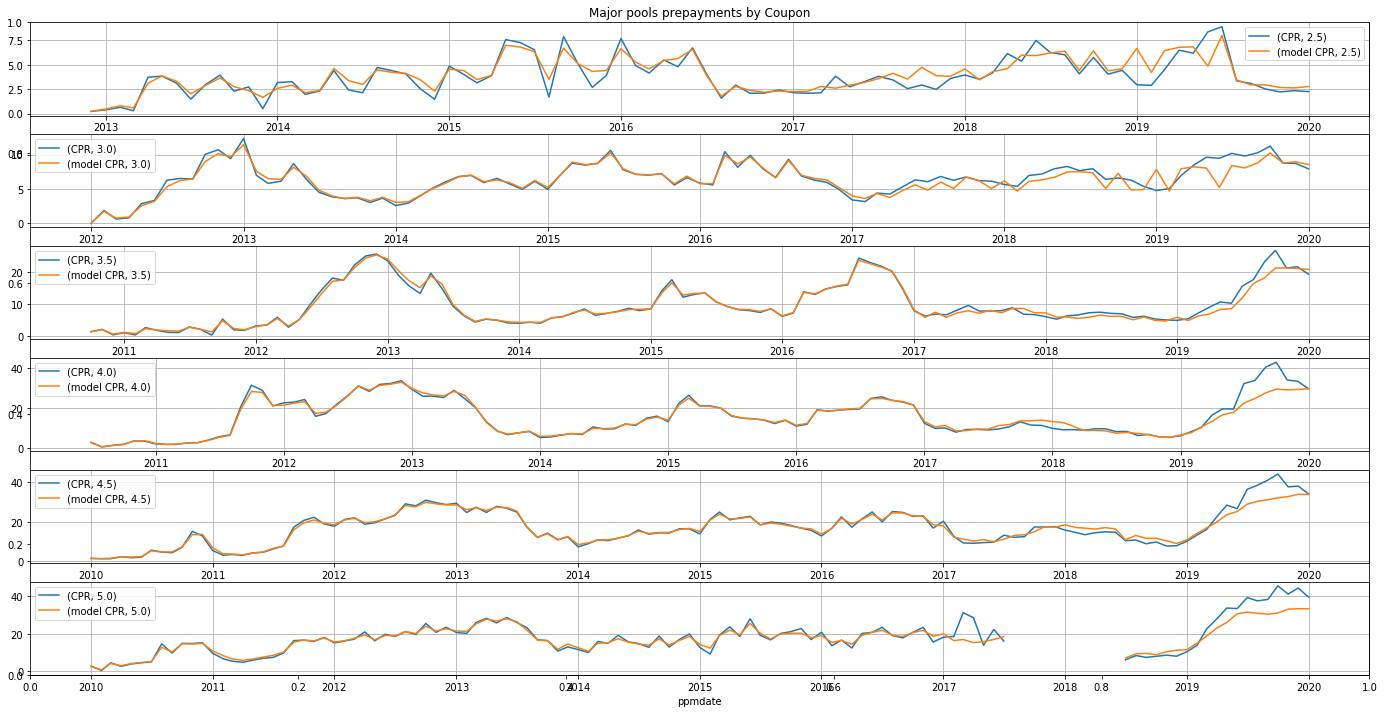

In [106]:
valReport(df[(df['%Majors'] == 100) & (df['Vintage'] > 2009)],graphTitle='Major pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

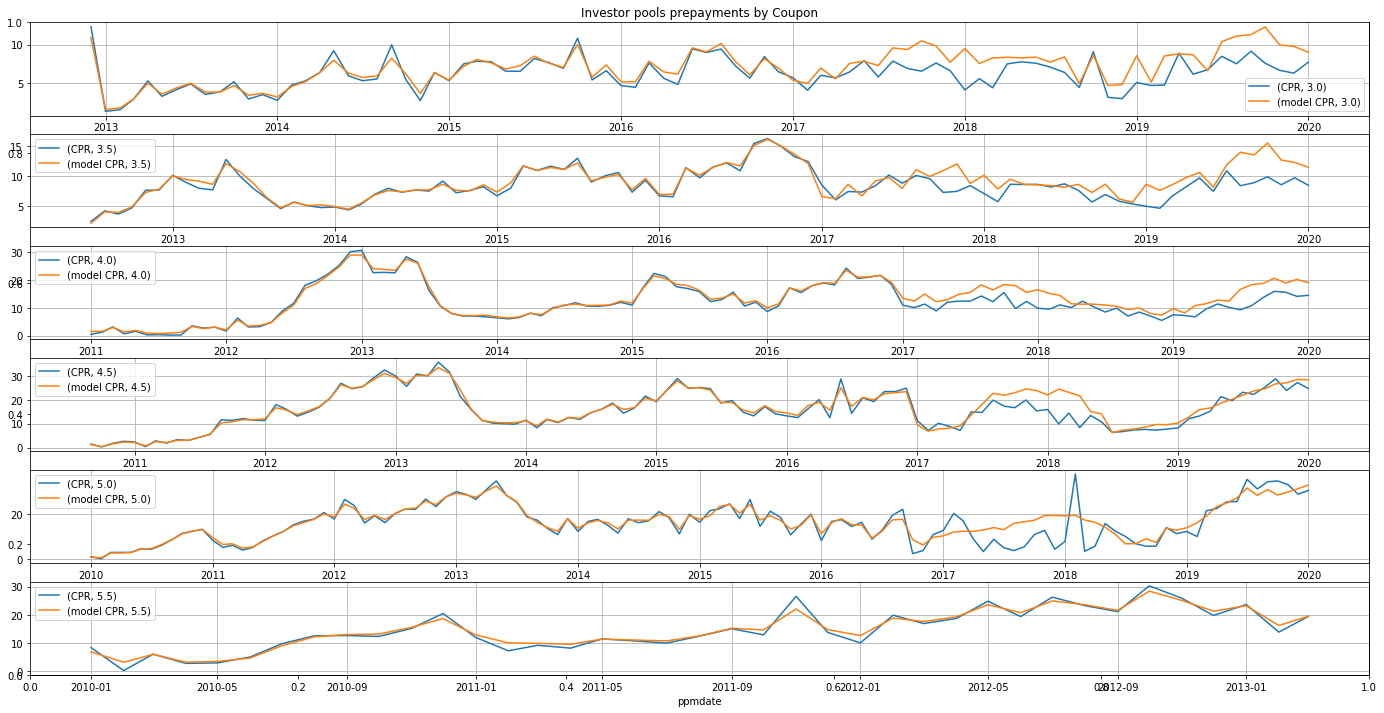

In [107]:
valReport(df[(df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

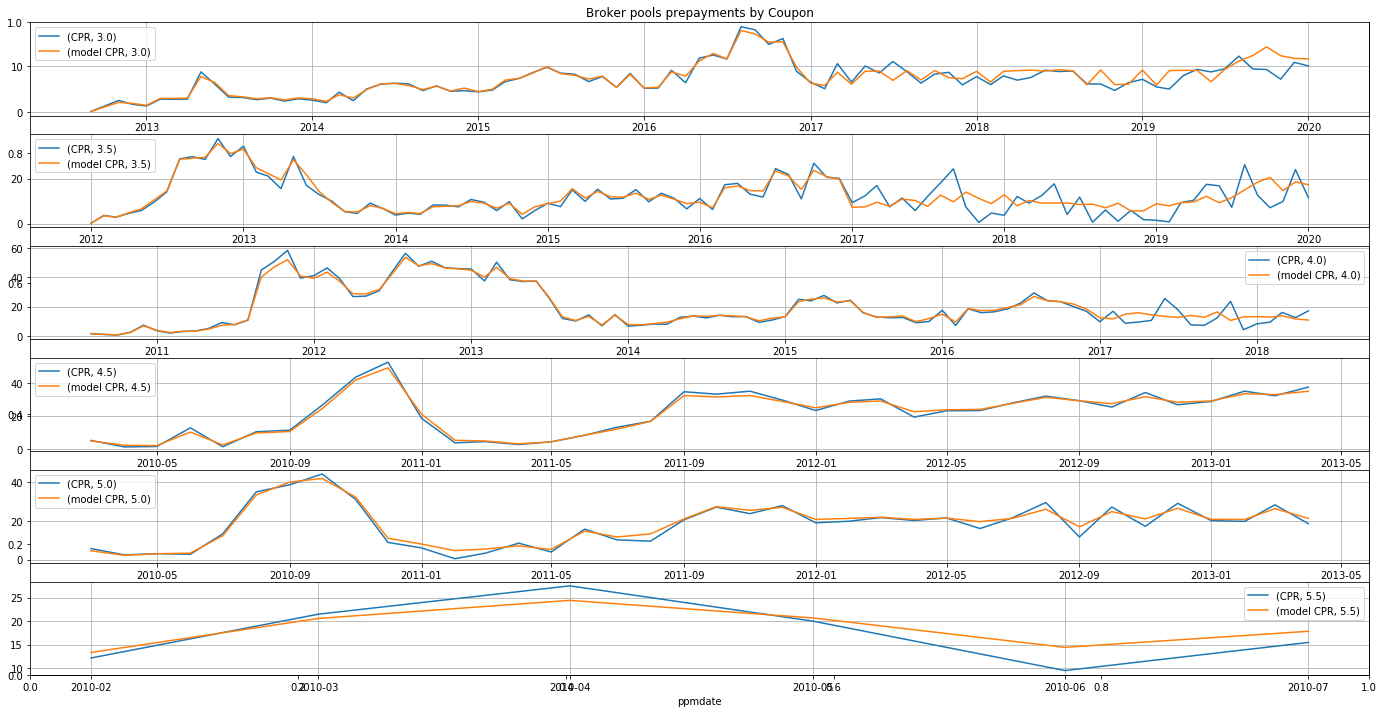

In [108]:
valReport(df[(df['PctChannel_Broker'] > 99) & (df['Vintage'] > 2009)],graphTitle='Broker pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

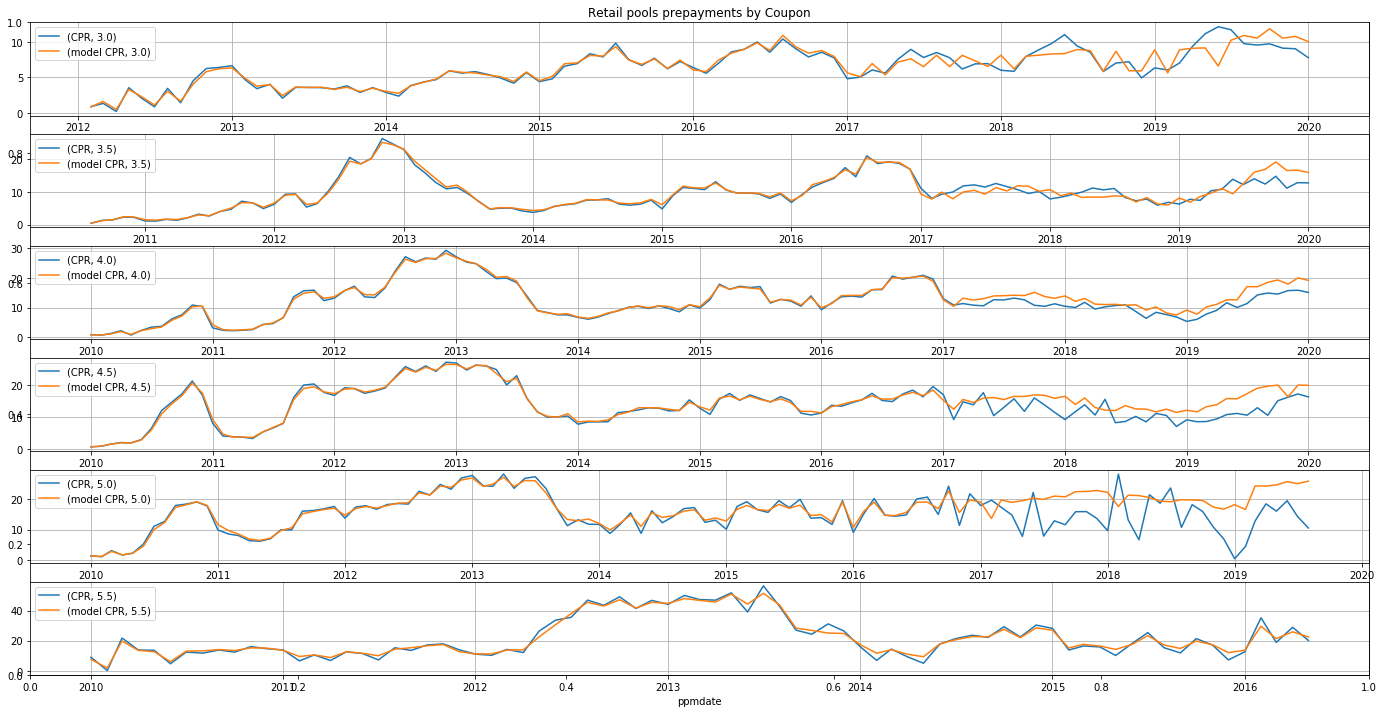

In [109]:
valReport(df[(df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

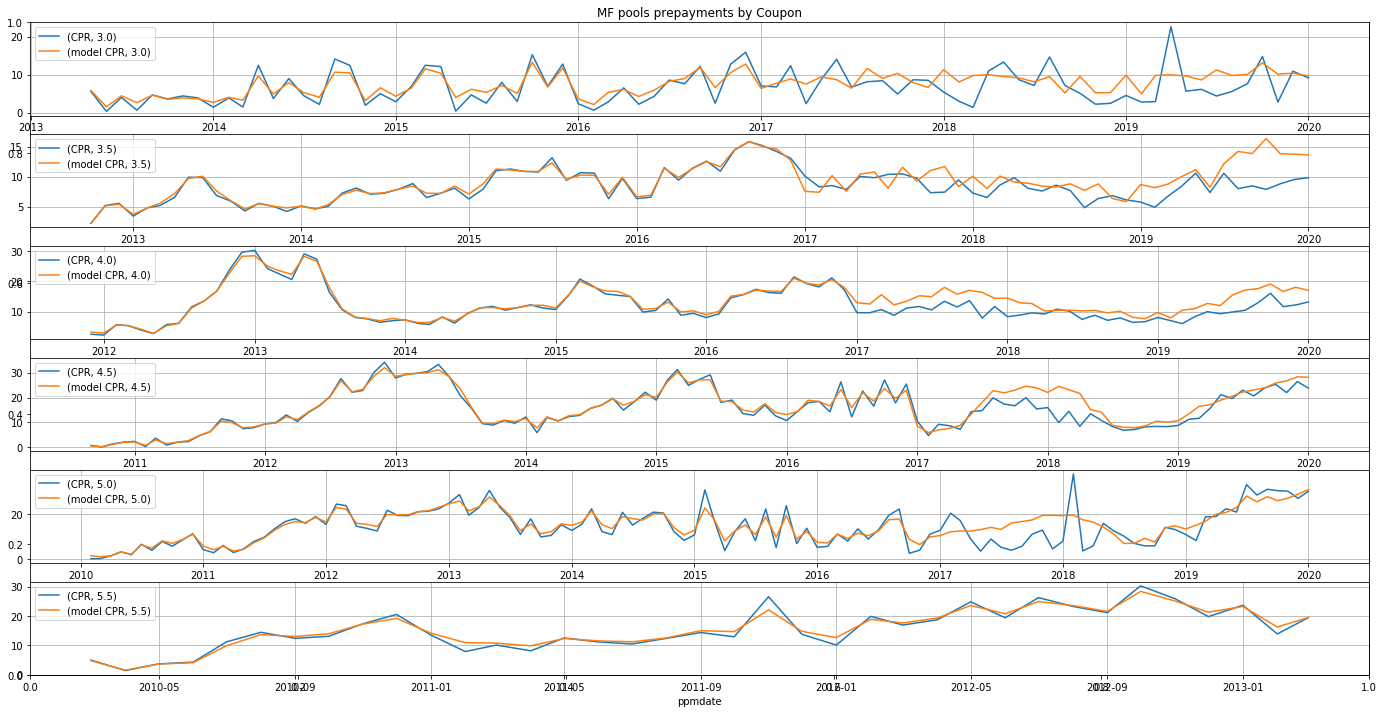

In [110]:
valReport(df[(df['PropUnitsPct_2-4'] > 25) & (df['Vintage'] > 2009)],graphTitle='MF pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

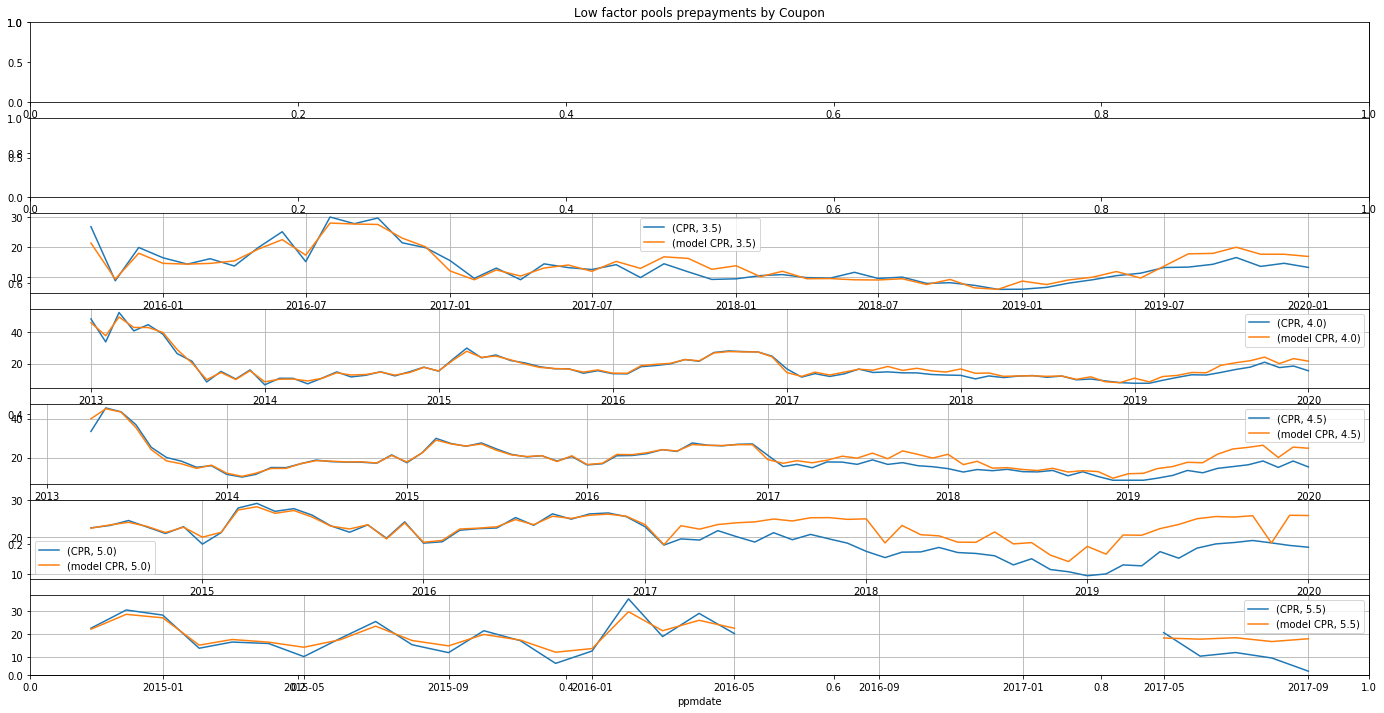

In [111]:
valReport(df[(df['factor'] < 30) & (df['Vintage'] > 2009)],graphTitle='Low factor pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5.5)

## Model Evaluation and Validation

* Here we find that although the model can be quite off on individual pools, overall it performes pretty well on large populations of loans. 
* In particular it performs very well on 
    * Loan balance pools, i.e. pools where loan size does not exceed 200k.
    * Cash window pools, i.e. pools originated by very small originators.
    * Retail originated loans, i.e. not Broker or Correspondent originated pools.

In [17]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.3935
(test set) mean sq root sq error     = 0.5419
(test set) explained variance score  = 0.3969


(train set) mean absolute error      = 0.3793
(train set) mean sq root sq error    = 0.5257
(train set) explained variance score = 0.7419


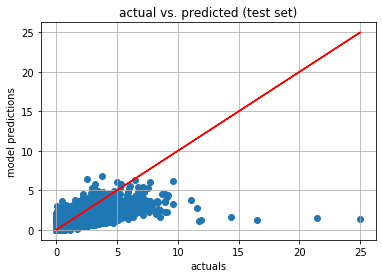

In [18]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

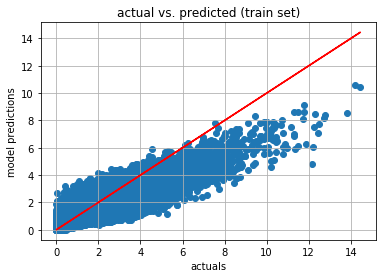

In [19]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

In [20]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
else:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop('SMM',axis=1)))

In [21]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

In [22]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)

    fig = plt.figure(figsize=fsize)
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

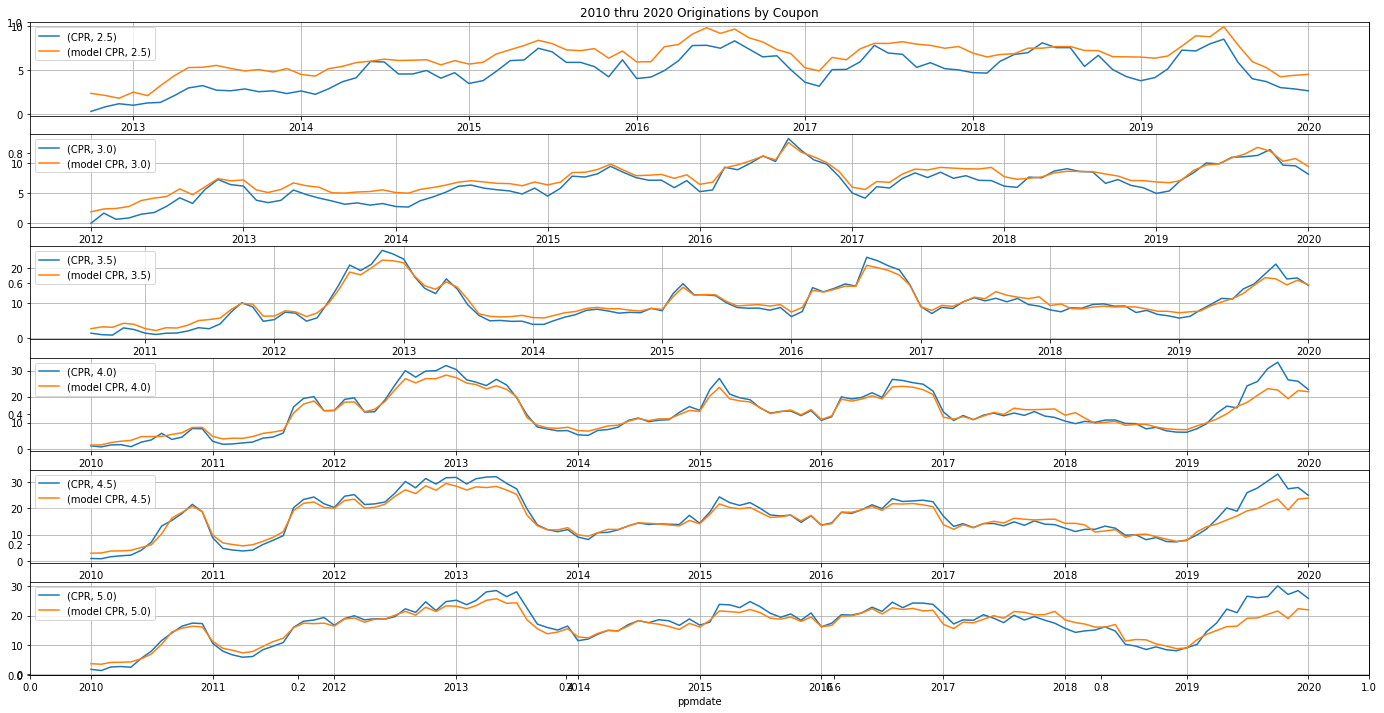

In [23]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

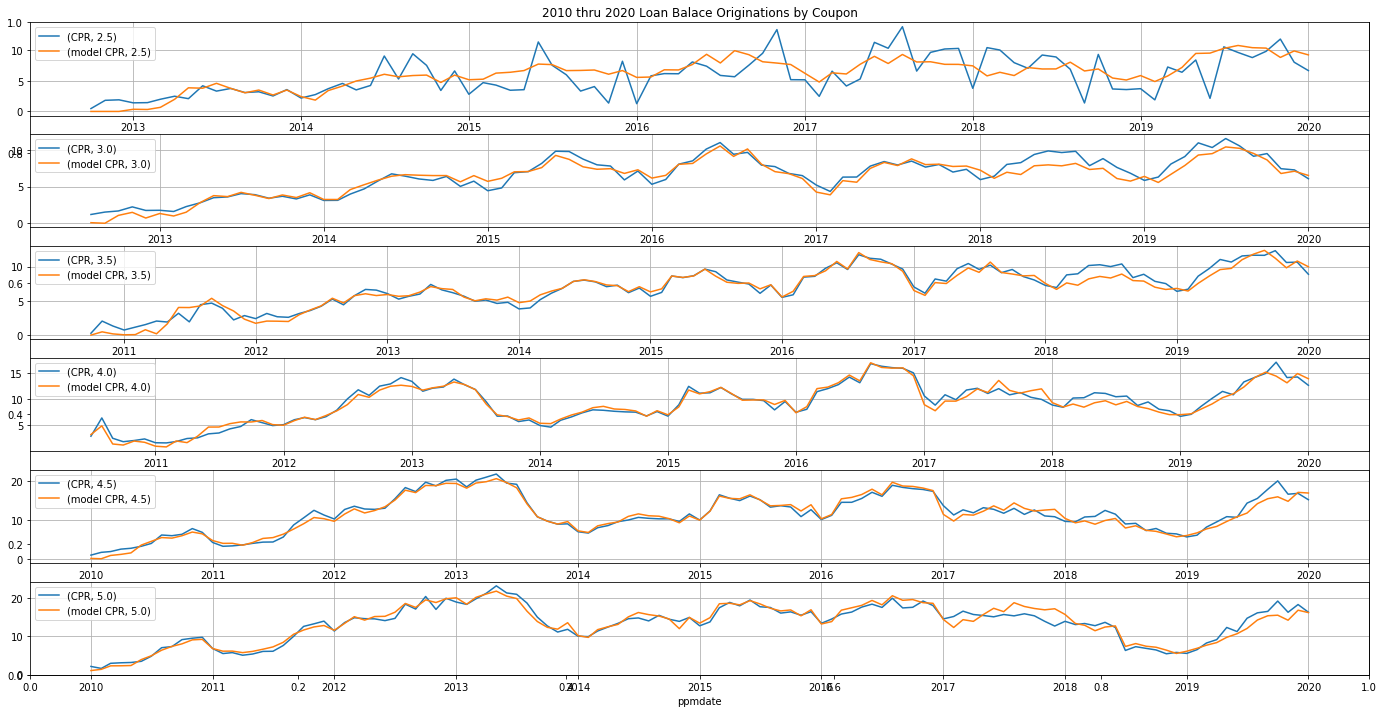

In [69]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

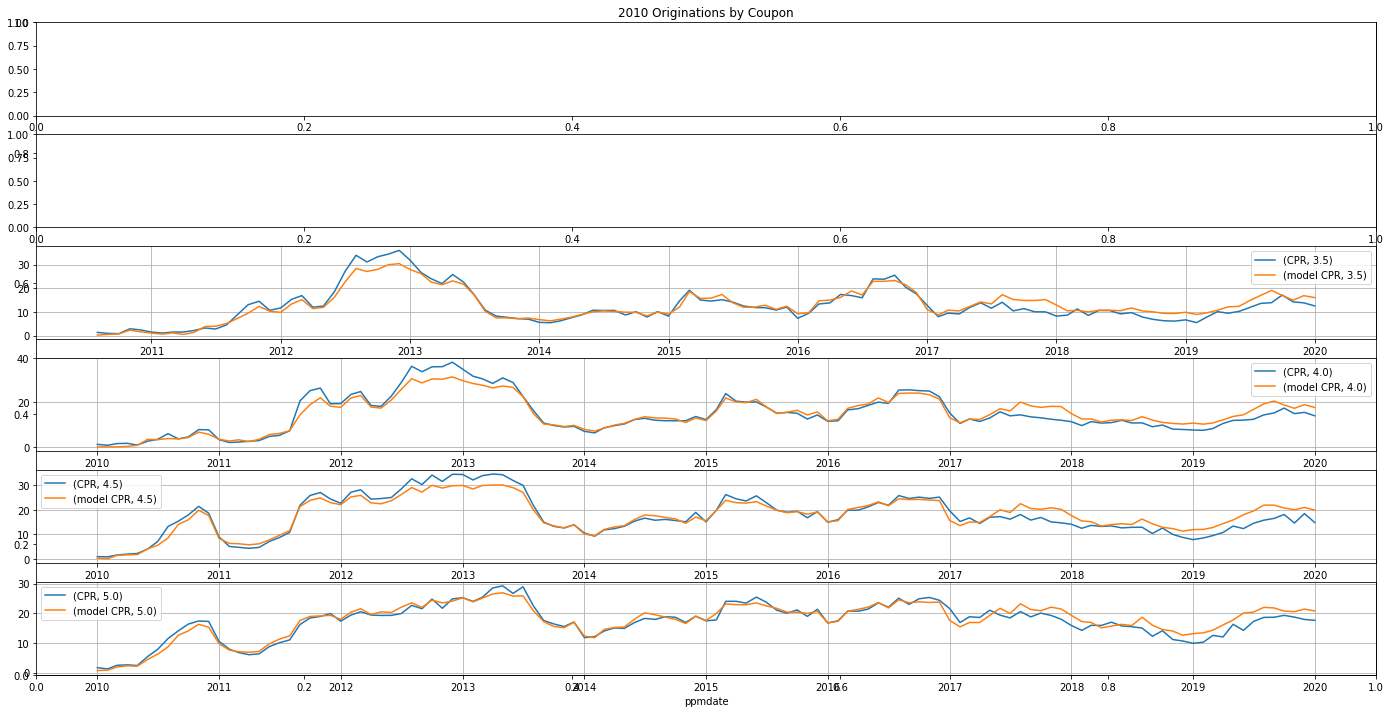

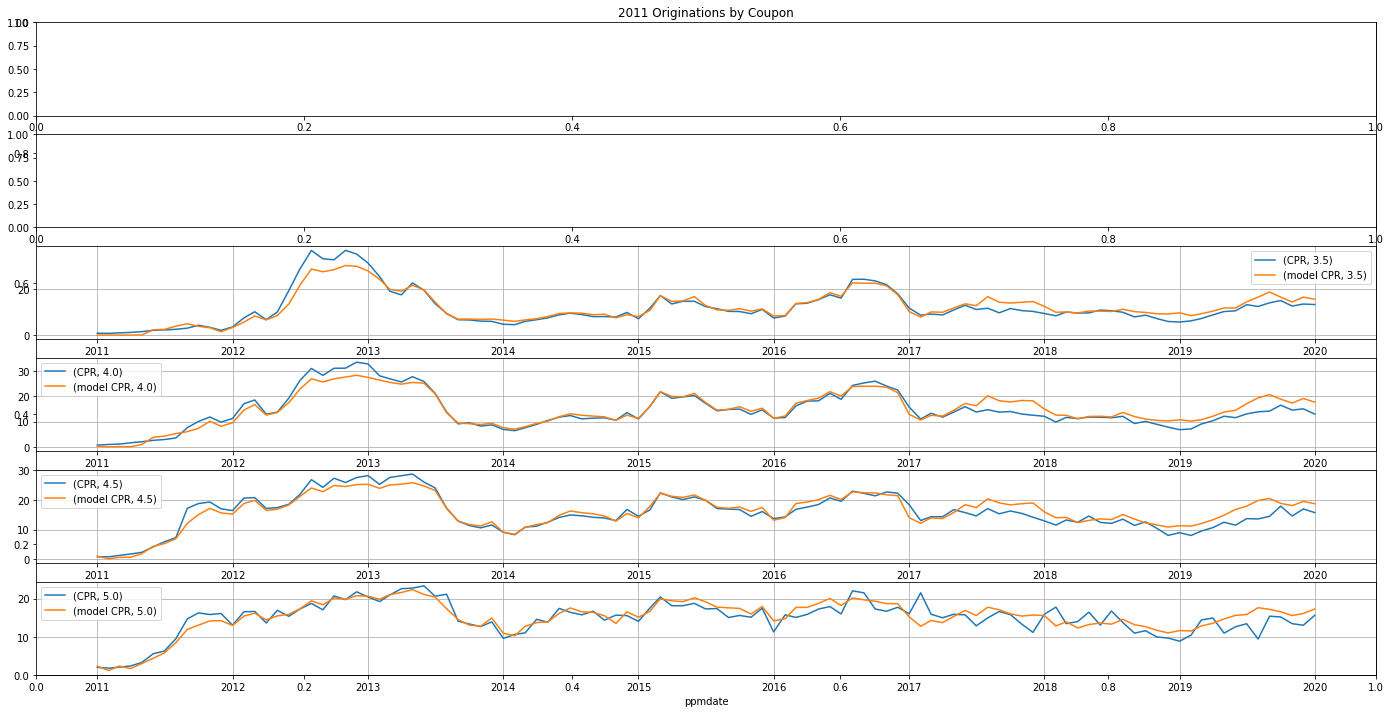

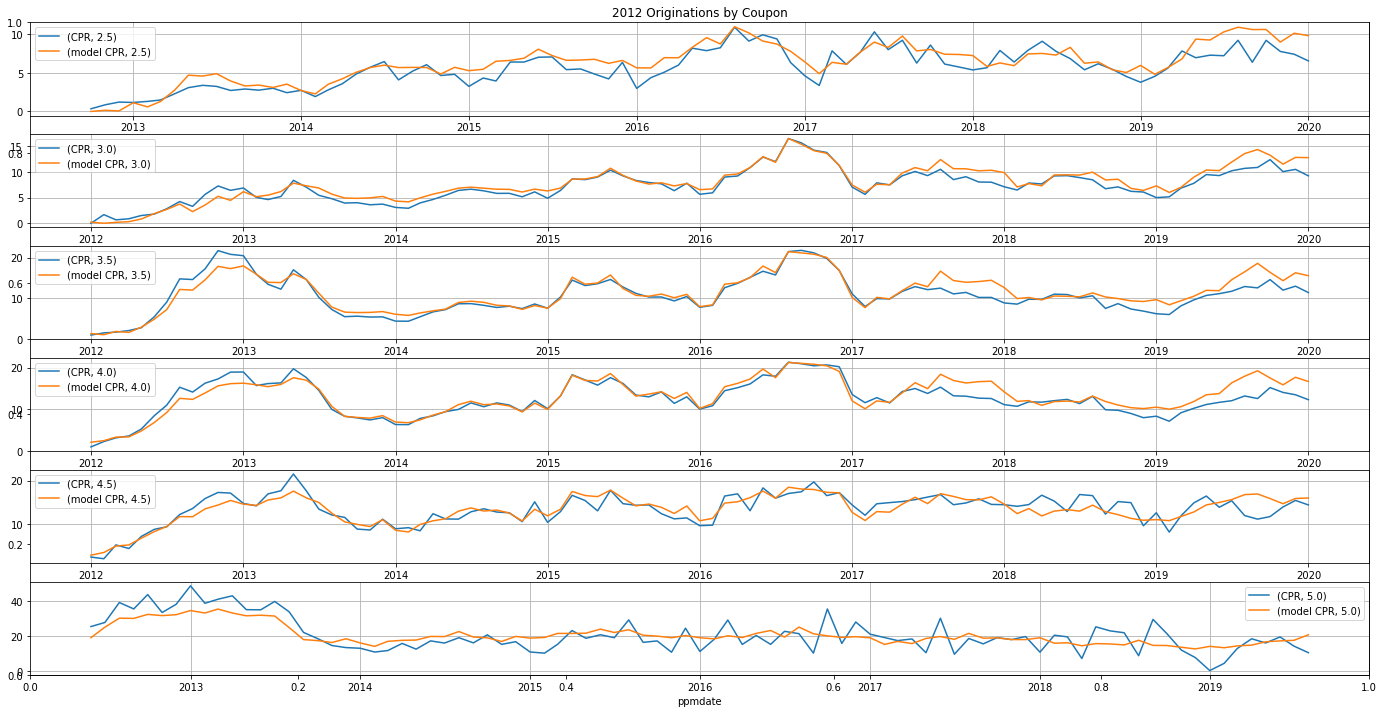

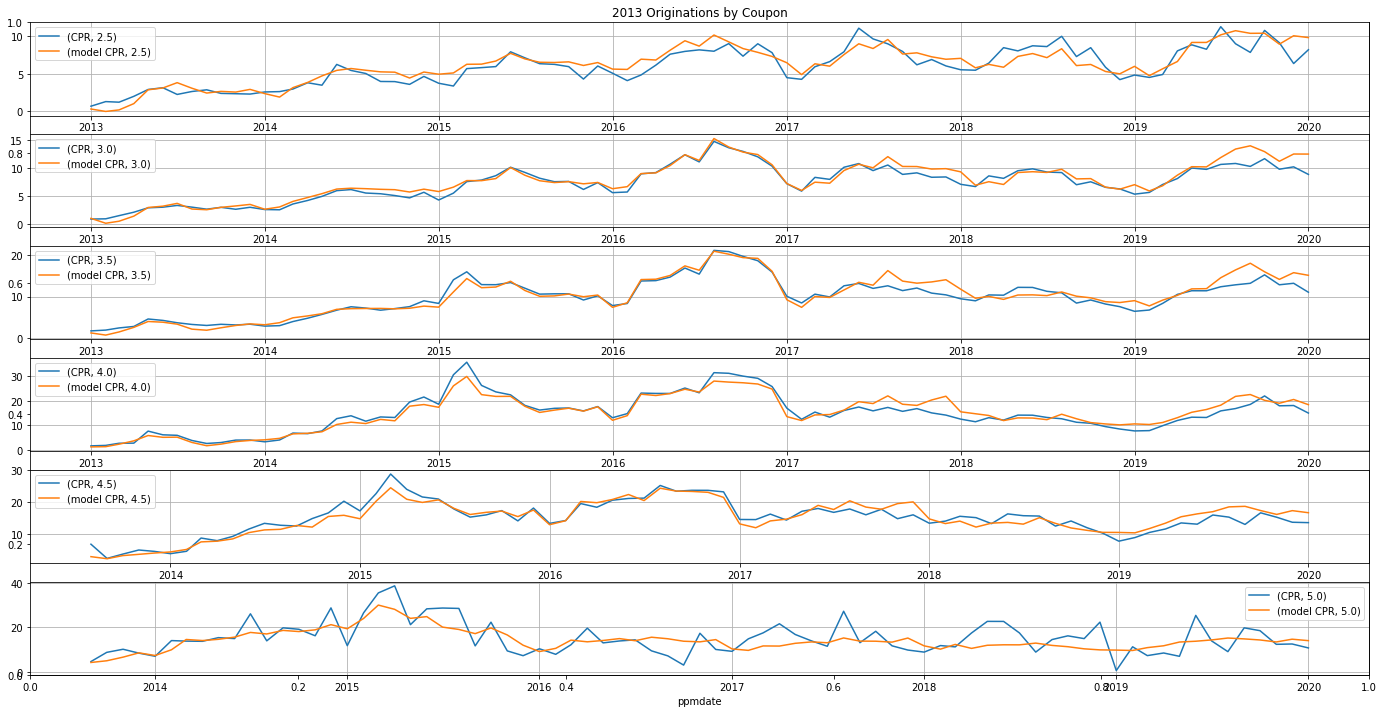

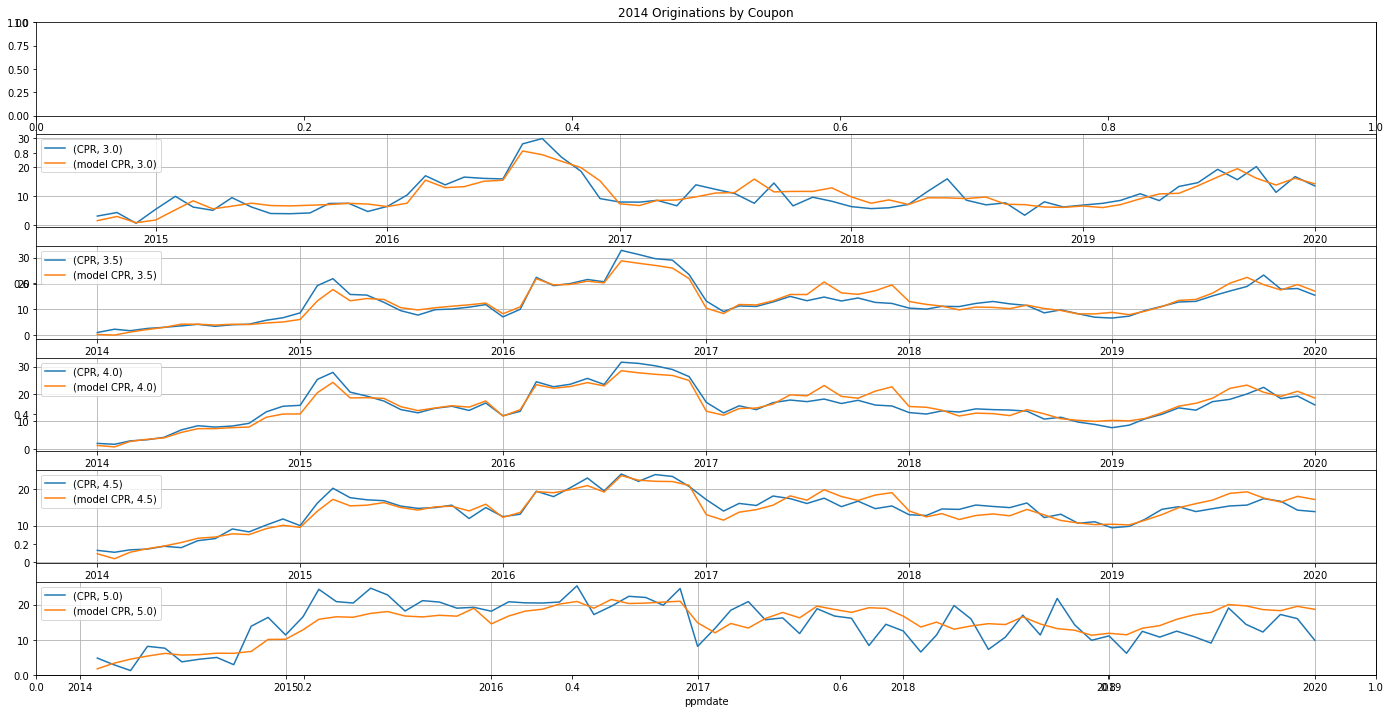

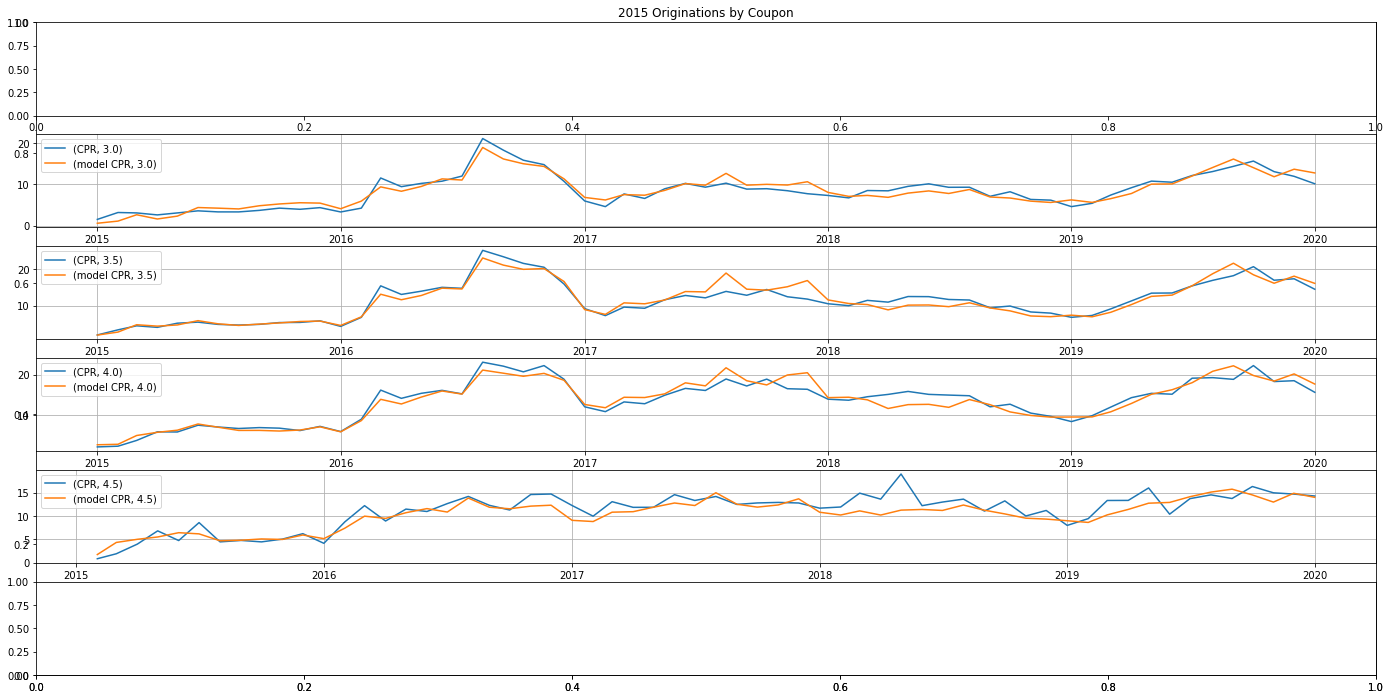

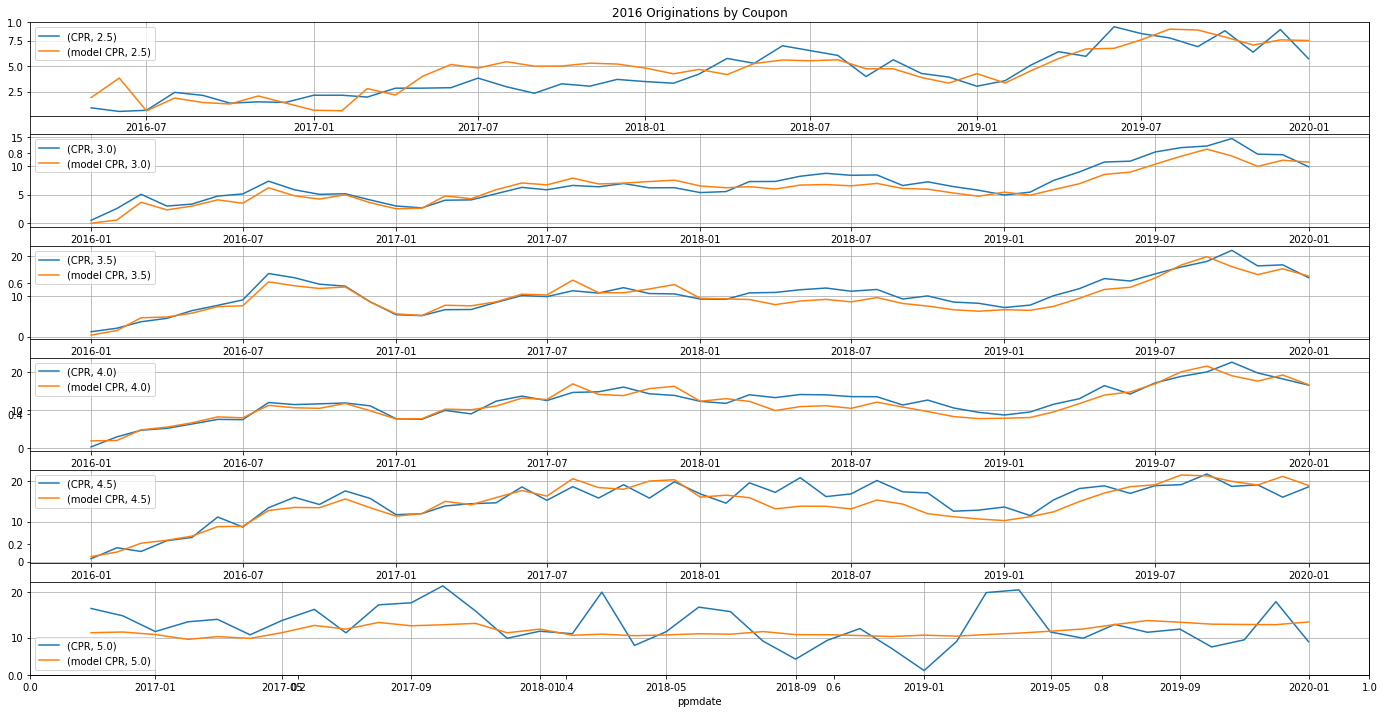

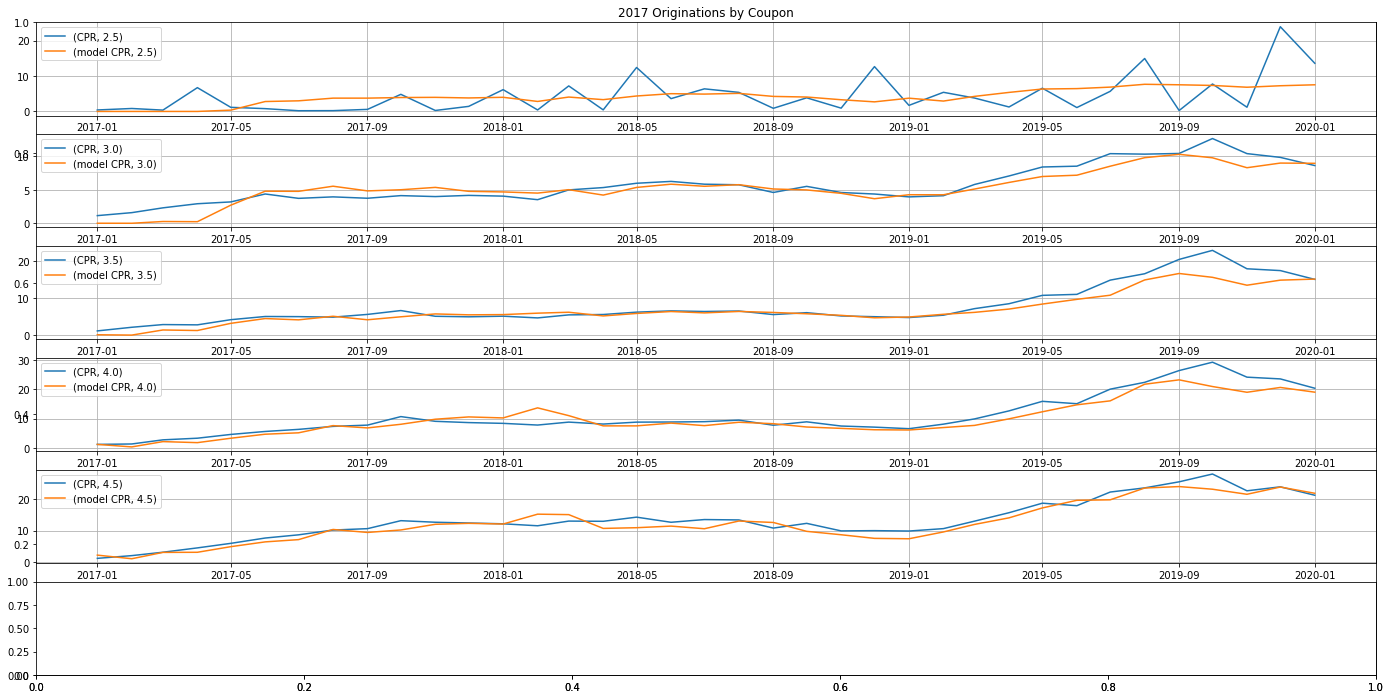

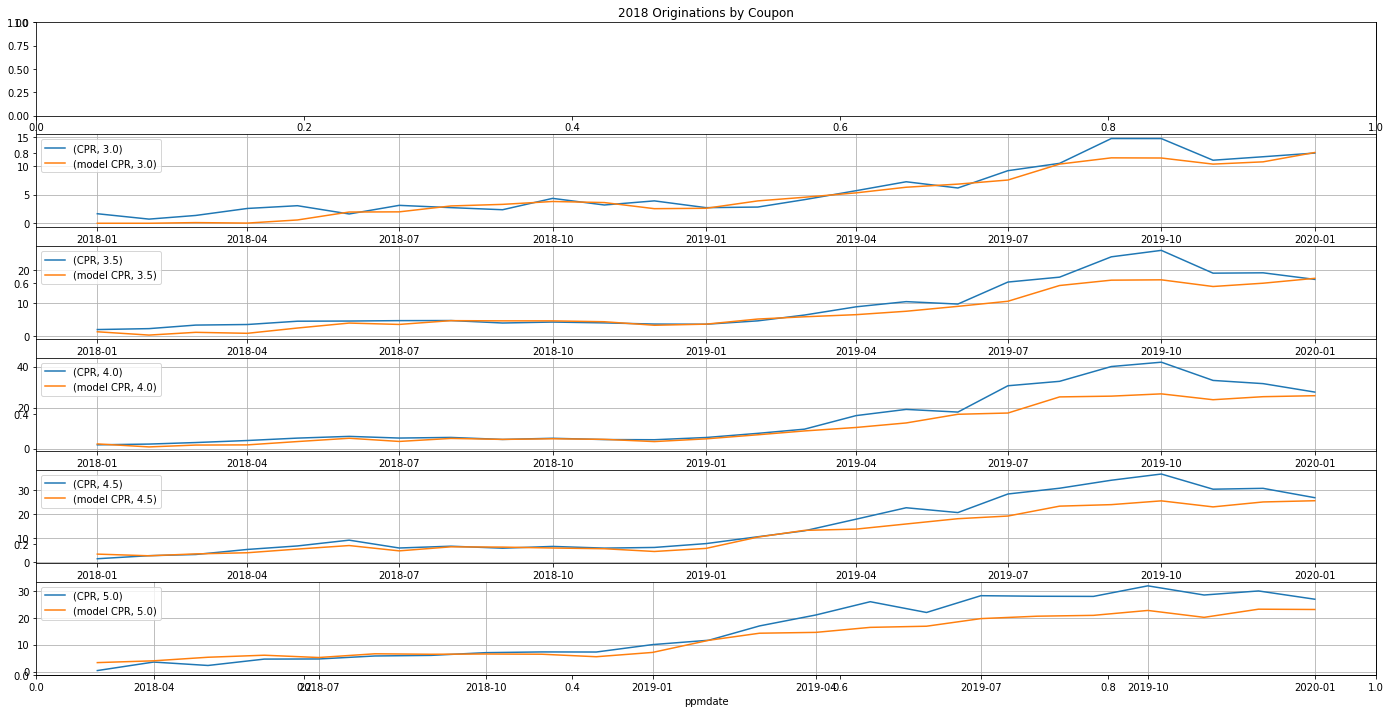

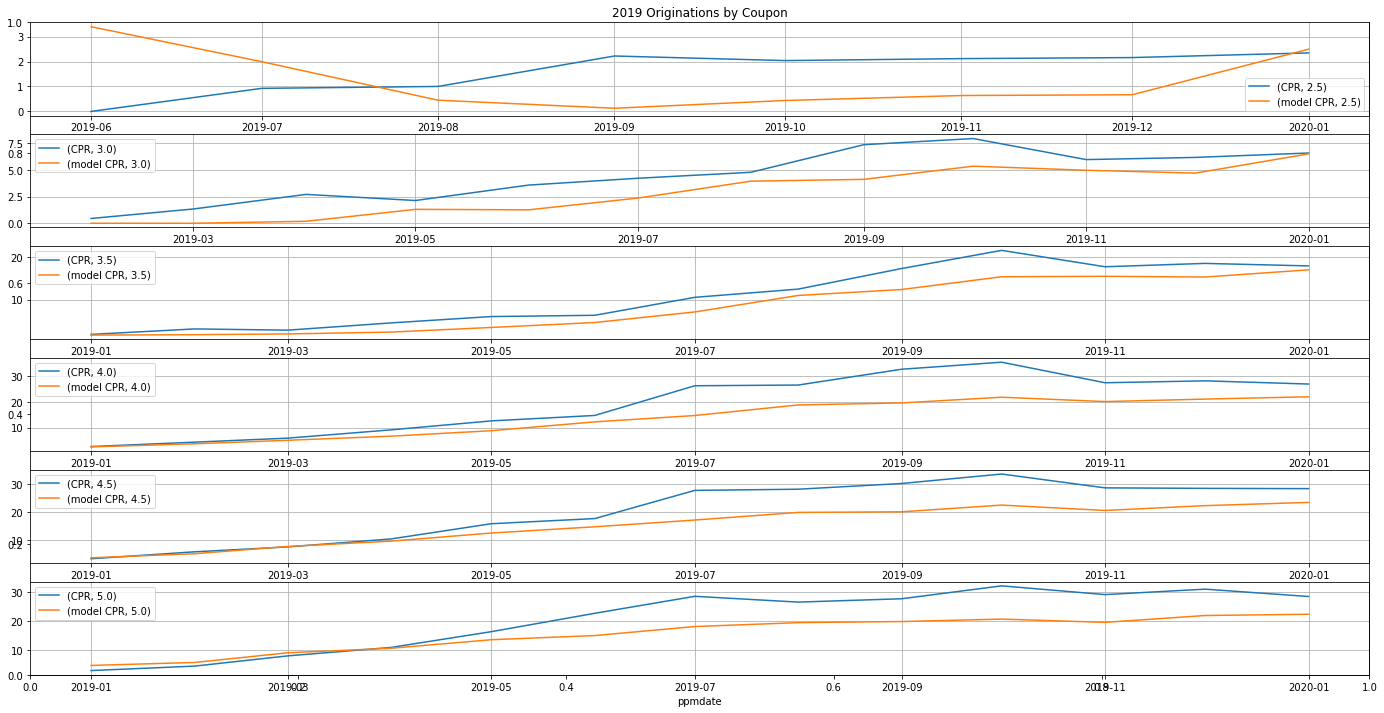

In [70]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:

    valReport(df[df['Vintage'] == vintage],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

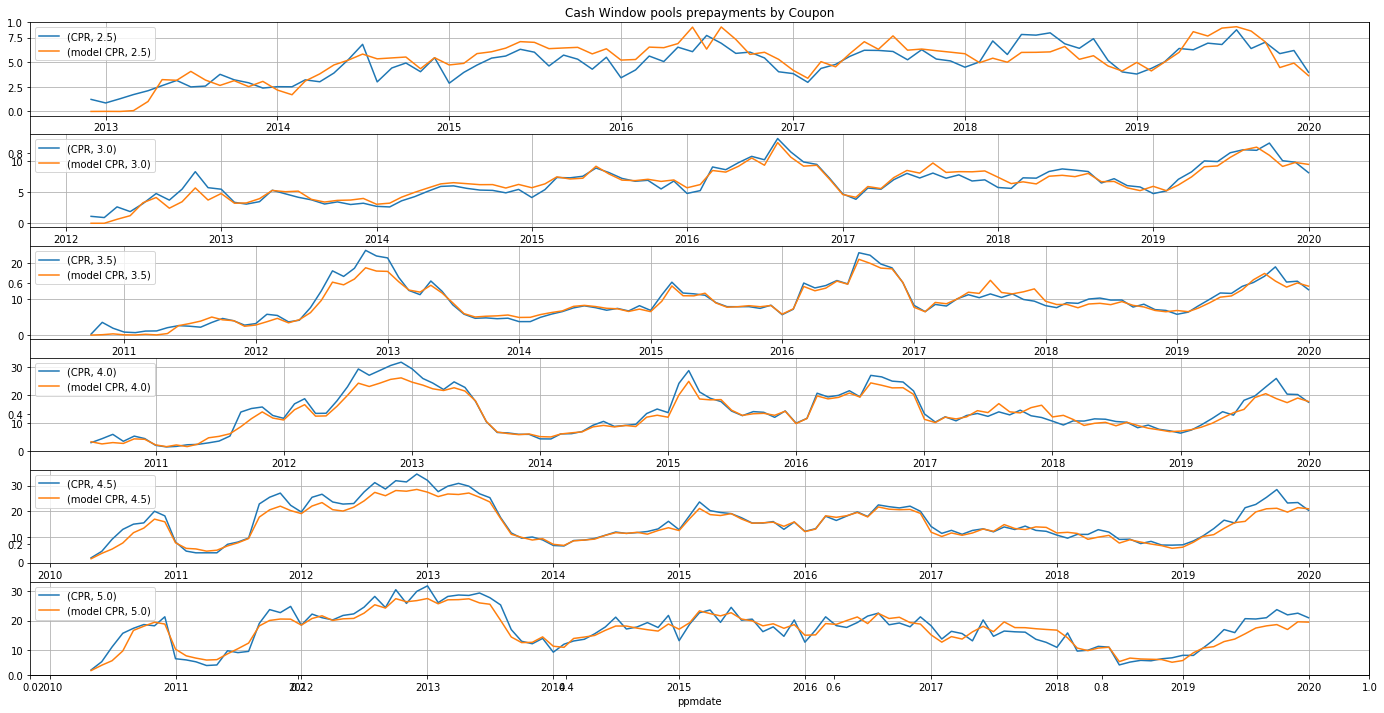

In [71]:
valReport(df[(df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

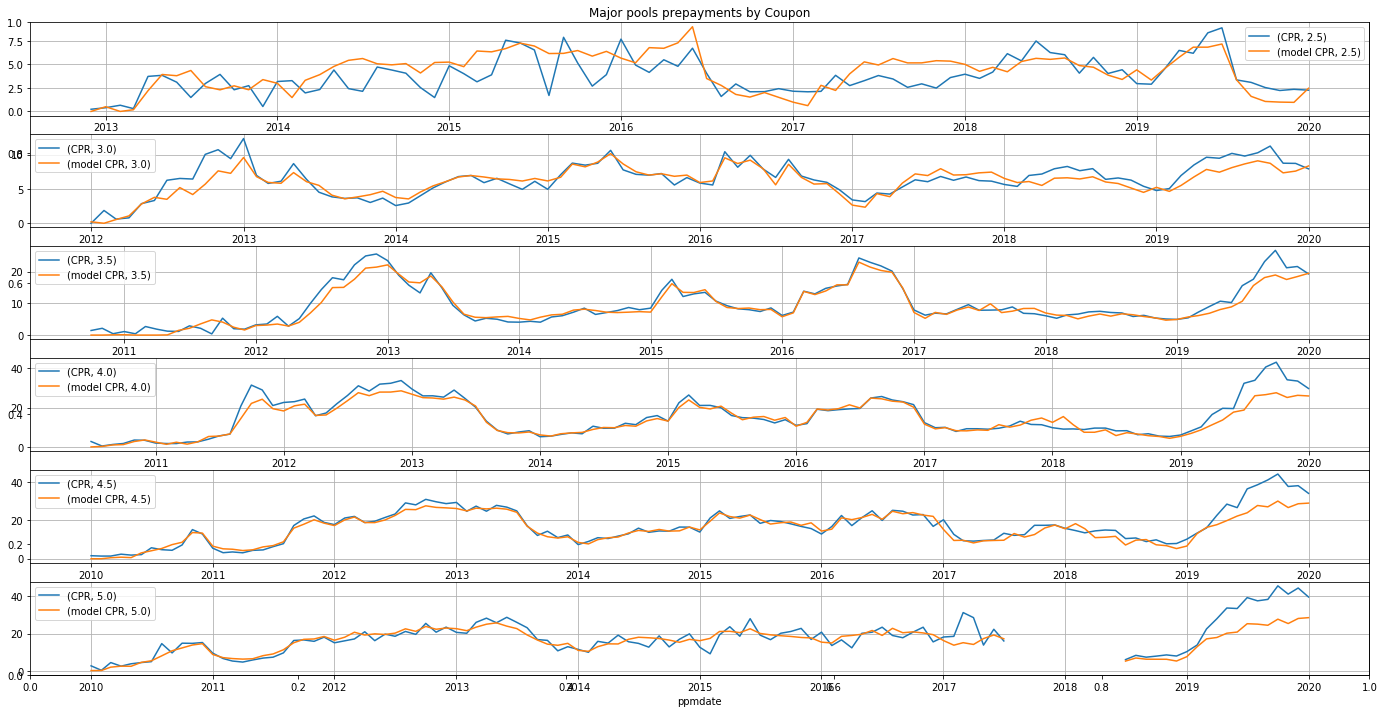

In [72]:
valReport(df[(df['%Majors'] == 100) & (df['Vintage'] > 2009)],graphTitle='Major pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

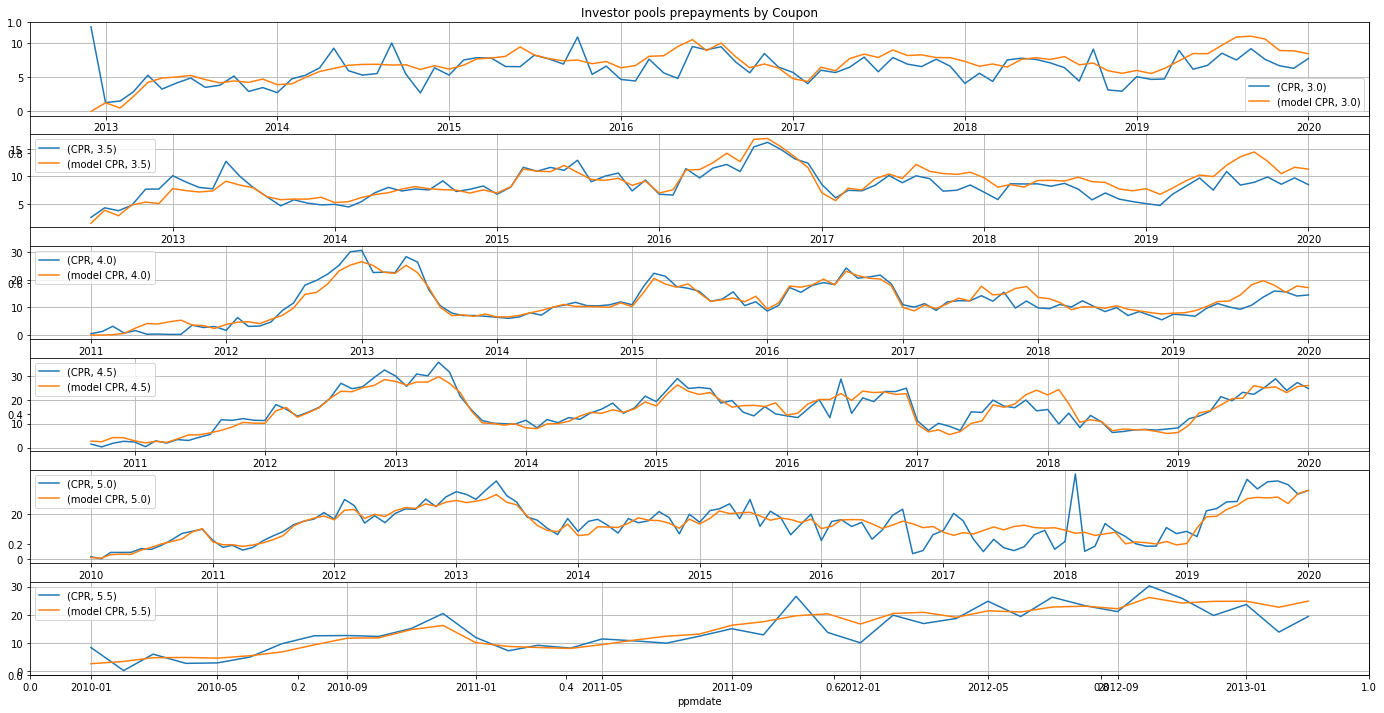

In [73]:
valReport(df[(df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

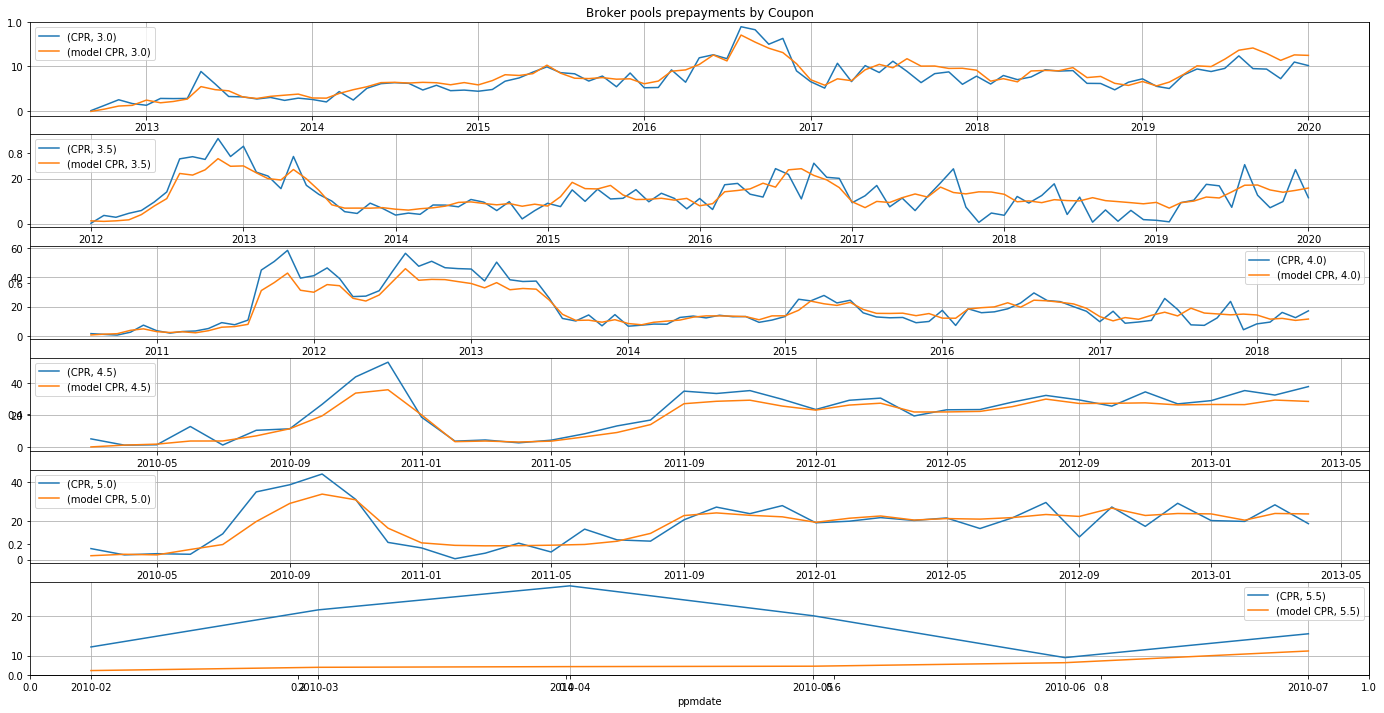

In [74]:
valReport(df[(df['PctChannel_Broker'] > 99) & (df['Vintage'] > 2009)],graphTitle='Broker pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

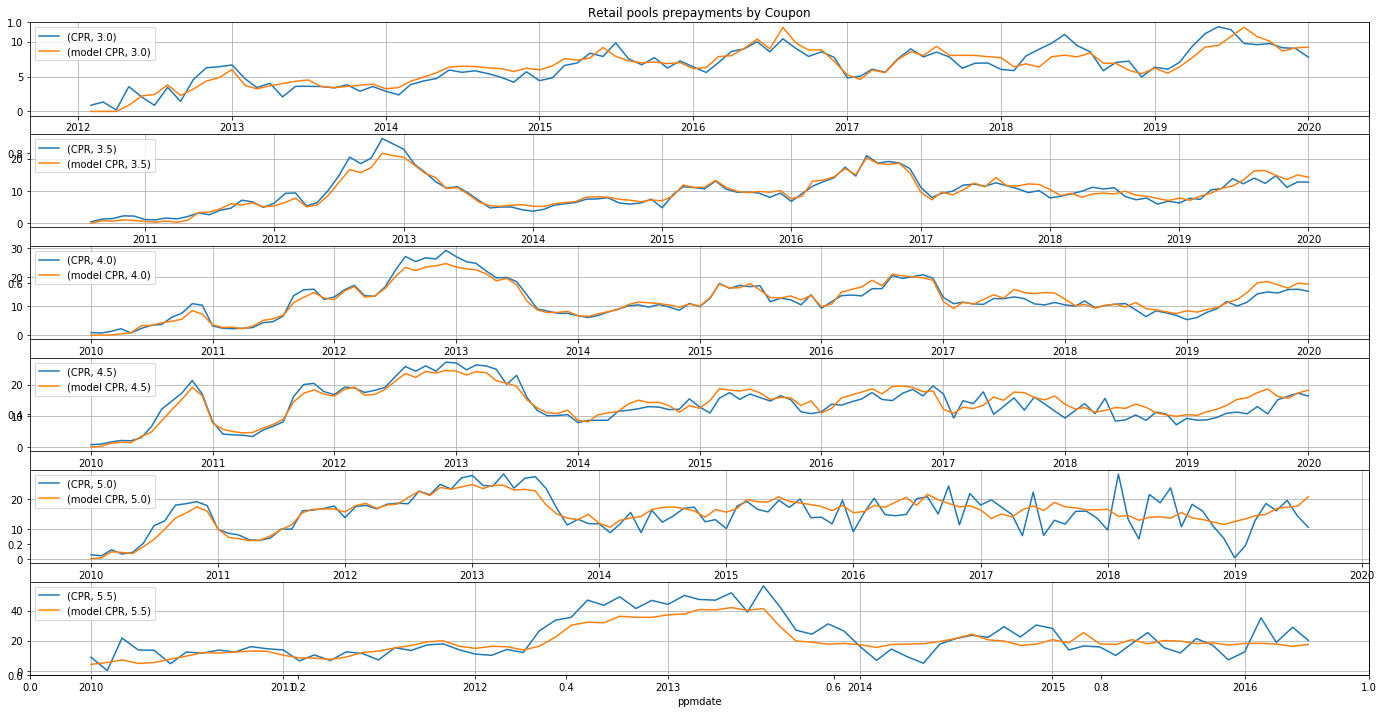

In [75]:
valReport(df[(df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

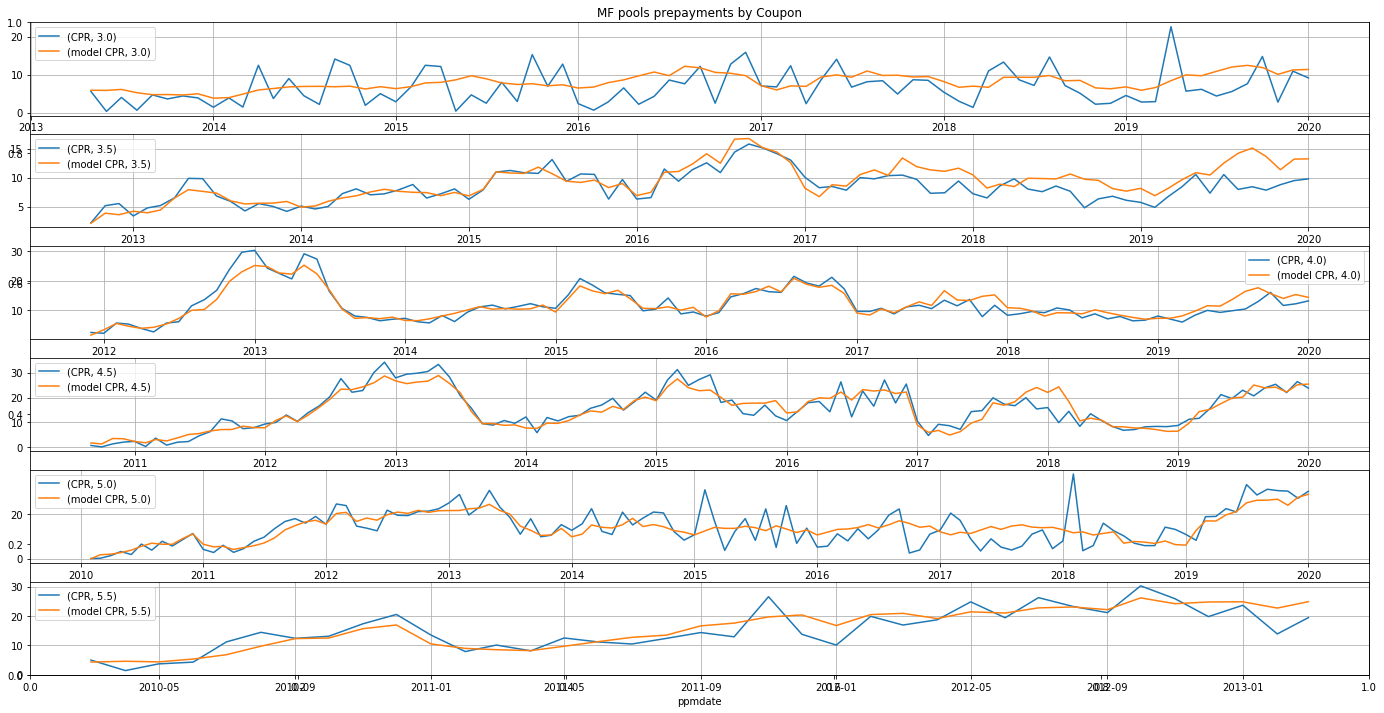

In [76]:
valReport(df[(df['PropUnitsPct_2-4'] > 25) & (df['Vintage'] > 2009)],graphTitle='MF pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

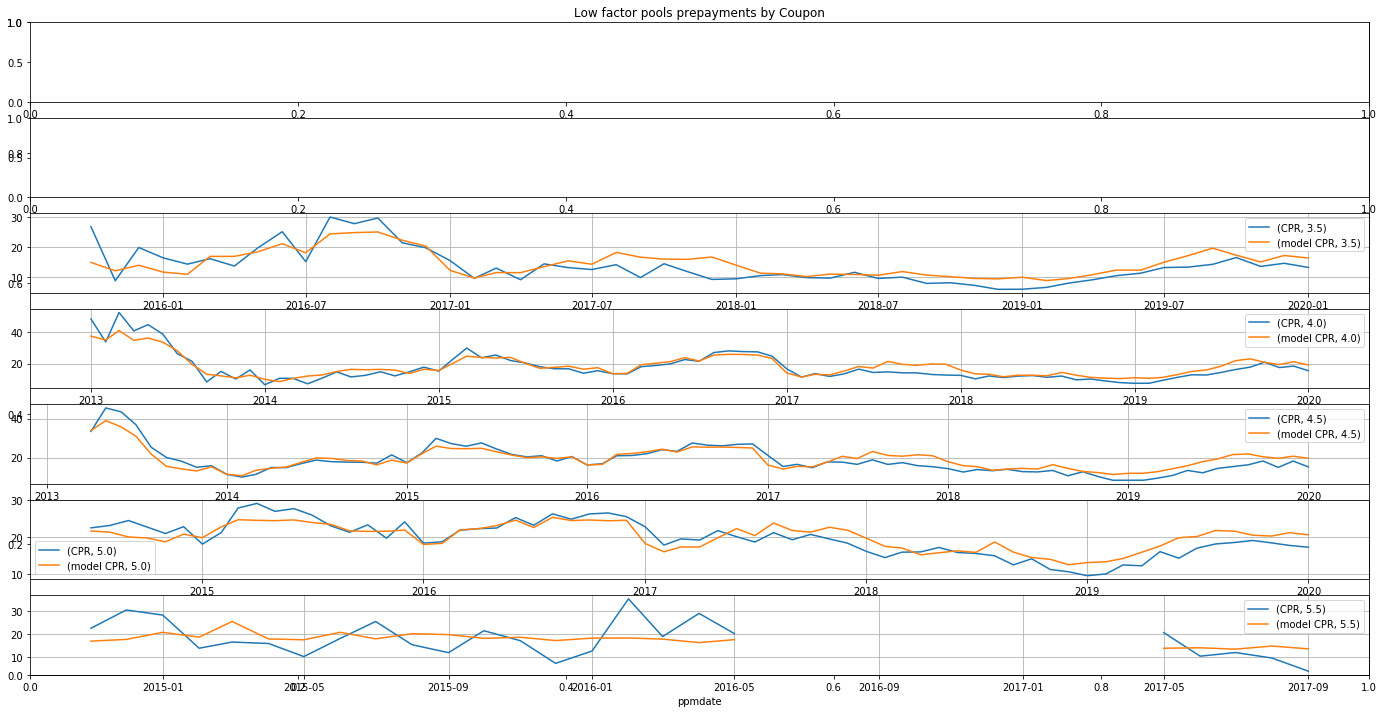

In [77]:
valReport(df[(df['factor'] < 30) & (df['Vintage'] > 2009)],graphTitle='Low factor pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5.5)

### Save the neural network prepayment model in .h5 format

In [14]:
from tensorflow.keras.models import load_model

In [80]:
model_name

'nn-ppm-from-csv.h5'

#### Uncomment the line below if you would like to save

In [81]:
# model.save(model_name)

#### Uncomment the line below if you would like to load the model saved in Git repository

In [16]:
# model = load_model('nn-ppm-from-csv.h5')

#### Please, ignore the section below. 

In [51]:
# import kerastuner as kt 

In [52]:
# def model_builder(hp):

#     model = Sequential()
    
#     #input layer / first hidden layer

#     first_layer_neurons      = hp.Int('layer_1_units', min_value=32, max_value = 1024, step = 32)
#     first_layer_dropout_rate = hp.Float('layer_1_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(first_layer_neurons, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(first_layer_dropout_rate))

#     # 2nd layer
#     second_layer_neurons      = hp.Int('layer_2_units', min_value=128, max_value = 512, step = 32)
#     second_layer_dropout_rate = hp.Float('layer_2_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(second_layer_neurons, activation='relu'))
#     model.add(Dropout(second_layer_dropout_rate))

#     # 3rd layer
#     third_layer_neurons      = hp.Int('layer_3_units', min_value=64, max_value = 256, step = 32)
#     third_layer_dropout_rate = hp.Float('layer_3_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(third_layer_neurons, activation='relu'))
#     model.add(Dropout(third_layer_dropout_rate))

#     # 4th layer
#     forth_layer_neurons      = hp.Int('layer_4_units', min_value=32, max_value = 128, step = 32)
#     forth_layer_dropout_rate = hp.Float('layer_4_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(forth_layer_neurons, activation='relu'))
#     model.add(Dropout(forth_layer_dropout_rate))

#     #output layer
#     model.add(Dense(1, activation='relu')) # relu activation is perfect here, because SMM cannot be negative

#     model.compile(optimizer='adam', loss='mse')
#     #model.compile(optimizer='rmsprop', loss='mse')    

#     return model

In [53]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_loss',
#                      max_epochs=10,
#                      hyperband_iterations=2,
#                      directory=os.path.normpath('C:/'),
#                      project_name='nn_ppm_model-' + dt.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))

In [54]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1024,
#              epochs=10)

In [55]:
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [56]:
# model = tuner.hypermodel.build(best_hps)

In [57]:
# model.summary()

In [58]:
# tuner.results_summary()